# Group-Based Machine Learning for Educational Access Prediction

# 1) Introduction
Access to elite higher education institutions has long been a central topic in discussions surrounding educational equity. In the United States, Ivy League and other highly selective private universities are seen as gateways to significant social and economic mobility. However, concerns remain about whether students from different socioeconomic backgrounds have equitable access to these institutions.

This project explores the relationship between student group characteristics and their likelihood of being admitted to private Ivy League universities. The dataset used in this study summarizes institutional-level statistics on application, admission, and enrollment outcomes disaggregated by parental income percentiles. Each record corresponds to a specific income group at a specific college, providing a rich basis for understanding how group-level behaviors and income status influence elite college admissions.

The primary research question is: \emph{To what extent can group-level features predict the likelihood of admission to private Ivy League institutions, and what do these patterns reveal about systemic inequality in access to higher education?}

To address this, we build a supervised machine learning model to predict Ivy admission outcomes using four main features:
* **par_income_bin**: Parental income percentile bin for the student group. Used to capture the socioeconomic background of the student group, which influences access to resources and opportunities.

* **attend_level_sat**: Normalized college attendance rate among students who submitted SAT scores. Used to indicate the academic engagement and selectivity-fit of the SAT-submitting subgroup, serving as a proxy for preparation and competitiveness.

* **rel_apply**: Relative application rate of the group to the institution. Used to reflect the interest and self-selection behavior of the student group toward selective colleges.

* **rel_att_cond_app**: Conditional admission rate given application, for the group. Used to measure the institution’s historical preference or acceptance tendency toward this group, helping model perceived fit or desirability.

By visualizing feature distributions, analyzing inter-feature correlations, applying dimensionality reduction (PCA), and training classification models, we aim to uncover both predictive patterns and structural disparities. Specifically, we examine whether higher-income groups consistently have higher chances of Ivy admission, even when controlling for behavioral indicators like test-taking and application rates.

Ultimately, this analysis not only seeks to build an effective predictive model, but also contributes to the broader conversation on educational access and fairness. Understanding how income-based group features correlate with elite admission outcomes may offer empirical support for policy interventions aimed at increasing equity in higher education.

## -Download the dataset

In [1]:
#Load the dataset
import pandas as pd

# Load the dataset
df = pd.read_csv("CollegeAdmissions_Data.csv")

# View the first few lines
print(df.head())

   super_opeid                 name  par_income_bin par_income_lab    attend  \
0         1434  American University            10.0           0-20  0.001122   
1         1434  American University            30.0          20-40  0.001005   
2         1434  American University            50.0          40-60  0.001408   
3         1434  American University            65.0          60-70  0.001488   
4         1434  American University            75.0          70-80  0.001501   

   stderr_attend  attend_level  attend_sat  stderr_attend_sat  \
0       0.000120      0.001609    0.001361           0.000236   
1       0.000094      0.001609    0.002062           0.000167   
2       0.000082      0.001609    0.001430           0.000150   
3       0.000092      0.001609    0.001405           0.000165   
4       0.000077      0.001609    0.001259           0.000131   

   attend_level_sat  ...  rel_apply_unwgt_oostate  \
0          0.001537  ...                      NaN   
1          0.001537  .

In [2]:
df

,super_opeid,name,par_income_bin,par_income_lab,attend,stderr_attend,attend_level,attend_sat,stderr_attend_sat,attend_level_sat,...,rel_apply_unwgt_oostate,stderr_rel_apply_unwgt_instate,stderr_rel_apply_unwgt_oostate,rel_att_cond_app_unwgt_instate,rel_att_cond_app_unwgt_oostate,public,flagship,tier,tier_name,test_band_tier
0,1434,American University,10.000000,0-20,0.001122,0.000120,0.001609,0.001361,0.000236,0.001537,...,NaN,NaN,NaN,NaN,NaN,Private,0,Highly selective private,Highly selective private,Other Top 100 Private
1,1434,American University,30.000000,20-40,0.001005,0.000094,0.001609,0.002062,0.000167,0.001537,...,NaN,NaN,NaN,NaN,NaN,Private,0,Highly selective private,Highly selective private,Other Top 100 Private
2,1434,American University,50.000000,40-60,0.001408,0.000082,0.001609,0.001430,0.000150,0.001537,...,NaN,NaN,NaN,NaN,NaN,Private,0,Highly selective private,Highly selective private,Other Top 100 Private
3,1434,American University,65.000000,60-70,0.001488,0.000092,0.001609,0.001405,0.000165,0.001537,...,NaN,NaN,NaN,NaN,NaN,Private,0,Highly selective private,Highly selective private,Other Top 100 Private
4,1434,American University,75.000000,70-80,0.001501,0.000077,0.001609,0.001259,0.000131,0.001537,...,NaN,NaN,NaN,NaN,NaN,Private,0,Highly selective private,Highly selective private,Other Top 100 Private
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1941,2903,Yeshiva University,97.500000,97-98,0.001551,0.000148,0.000682,0.000981,0.000271,0.000463,...,NaN,NaN,NaN,NaN,NaN,Private,0,Selective private,Selective private,Other Top 100 Private
1942,2903,Yeshiva University,98.500000,98-99,0.001668,0.000142,0.000682,0.001646,0.000298,0.000463,...,NaN,NaN,NaN,NaN,NaN,Private,0,Selective private,Selective private,Other Top 100 Private
1943,2903,Yeshiva University,99.400002,99-99.9,0.002009,0.000152,0.000682,NaN,NaN,0.000463,...,NaN,NaN,NaN,NaN,NaN,Private,0,Selective private,Selective private,Other Top 100 Private
1944,2903,Yeshiva University,99.500000,Top 1,0.002033,0.000144,0.000682,0.002257,0.000362,0.000463,...,NaN,NaN,NaN,NaN,NaN,Private,0,Selective private,Selective private,Other Top 100 Private


## Step 1: Deal with the missing values

In [3]:
import pandas as pd

def handle_missing_values(df):
    threshold = 0.5  # Threshold: 50% missing

    for col in df.columns:
        # Only apply to int or float columns
        if not pd.api.types.is_numeric_dtype(df[col]):
            continue  # Skip non-numeric columns

        missing_ratio = df[col].isna().mean()

        if missing_ratio == 0:
            continue  # No missing values, skip this column

        if missing_ratio <= threshold:
            # Fill missing values with mean if column is numeric and missing ratio is low
            df[col] = df[col].fillna(df[col].mean())
        else:
            # Add a binary missing indicator for high-missing columns
            df[f"{col}_miss"] = df[col].notna().astype(int)  # 1 = not missing, 0 = missing

    return df

In [4]:
handle_missing_values(df)

,super_opeid,name,par_income_bin,par_income_lab,attend,stderr_attend,attend_level,attend_sat,stderr_attend_sat,attend_level_sat,...,rel_attend_unwgt_instate_miss,rel_attend_unwgt_oostate_miss,stderr_rel_attend_unwgt_instate_miss,stderr_rel_attend_unwgt_oostate_miss,rel_apply_unwgt_instate_miss,rel_apply_unwgt_oostate_miss,stderr_rel_apply_unwgt_instate_miss,stderr_rel_apply_unwgt_oostate_miss,rel_att_cond_app_unwgt_instate_miss,rel_att_cond_app_unwgt_oostate_miss
0,1434,American University,10.000000,0-20,0.001122,0.000120,0.001609,0.001361,0.000236,0.001537,...,0,0,0,0,0,0,0,0,0,0
1,1434,American University,30.000000,20-40,0.001005,0.000094,0.001609,0.002062,0.000167,0.001537,...,0,0,0,0,0,0,0,0,0,0
2,1434,American University,50.000000,40-60,0.001408,0.000082,0.001609,0.001430,0.000150,0.001537,...,0,0,0,0,0,0,0,0,0,0
3,1434,American University,65.000000,60-70,0.001488,0.000092,0.001609,0.001405,0.000165,0.001537,...,0,0,0,0,0,0,0,0,0,0
4,1434,American University,75.000000,70-80,0.001501,0.000077,0.001609,0.001259,0.000131,0.001537,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1941,2903,Yeshiva University,97.500000,97-98,0.001551,0.000148,0.000682,0.000981,0.000271,0.000463,...,0,0,0,0,0,0,0,0,0,0
1942,2903,Yeshiva University,98.500000,98-99,0.001668,0.000142,0.000682,0.001646,0.000298,0.000463,...,0,0,0,0,0,0,0,0,0,0
1943,2903,Yeshiva University,99.400002,99-99.9,0.002009,0.000152,0.000682,0.004009,0.000484,0.000463,...,0,0,0,0,0,0,0,0,0,0
1944,2903,Yeshiva University,99.500000,Top 1,0.002033,0.000144,0.000682,0.002257,0.000362,0.000463,...,0,0,0,0,0,0,0,0,0,0


## Step 2: Transform the text into lower case and replace space with underscore

In [5]:
#Tansform column name into lowercase
df['public'] = df['public'].str.lower()
df['tier'] = df['tier'].str.lower().str.replace(" ", "_")
df['tier_name'] = df['tier_name'].str.lower().str.replace(" ", "_")
df['test_band_tier'] = df['test_band_tier'].str.lower().str.replace(" ", "_")

## Step 3: Encode text into numeric value

In [6]:
# encode 'private' as 1，'public' as 0
df['public'] = df['public'].map({'private': 1, 'public': 0})

# one-hot encoding
target_tiers = [
    'highly_selective_private',
    'other_elite_schools_(public_and_private)',
    'selective_public',
    'highly_selective_public',
    'selective_private',
    'ivy_plus'
]
df['tier_name'] = df['tier_name'].apply(lambda x: x if x in target_tiers else 'Other')

# one-hot coding
dummies = pd.get_dummies(df['tier_name'], drop_first=False).astype(int)

# delete the original tier_name column (repitition)
df.drop(columns=['tier_name'], inplace=True)

# save the change
df = pd.concat([df, dummies], axis=1)



In [7]:
#Change true/ false to 0/1
df['highly_selective_private'] = df['highly_selective_private'].astype(int)
df['other_elite_schools_(public_and_private)'] = df['other_elite_schools_(public_and_private)'].astype(int)
df['selective_public'] = df['selective_public'].astype(int)
df['highly_selective_public'] = df['highly_selective_public'].astype(int)
df['selective_private'] = df['selective_private'].astype(int)
df['ivy_plus'] = df['ivy_plus'].astype(int)

df.drop(columns=['tier'], inplace=True)

In [8]:
# Clean the 'test_band_tier' column: strip whitespace and convert to lowercase
df['test_band_tier'] = df['test_band_tier'].astype(str).str.strip().str.lower()

# One-hot encode the 'test_band_tier' column (replace in-place)
dummies = pd.get_dummies(df['test_band_tier'], prefix='test_band', drop_first=False).astype(int)

# Drop the original 'test_band_tier' column
df.drop(columns=['test_band_tier'], inplace=True)

# Concatenate the one-hot encoded columns back to the DataFrame
df = pd.concat([df, dummies], axis=1)

In [9]:
df

,super_opeid,name,par_income_bin,par_income_lab,attend,stderr_attend,attend_level,attend_sat,stderr_attend_sat,attend_level_sat,...,ivy_plus,other_elite_schools_(public_and_private),selective_private,selective_public,test_band_flagship,test_band_ivy_plus,test_band_nescac,test_band_other_top_100_private,test_band_other_top_100_public,test_band_tier_2_private
0,1434,American University,10.000000,0-20,0.001122,0.000120,0.001609,0.001361,0.000236,0.001537,...,0,0,0,0,0,0,0,1,0,0
1,1434,American University,30.000000,20-40,0.001005,0.000094,0.001609,0.002062,0.000167,0.001537,...,0,0,0,0,0,0,0,1,0,0
2,1434,American University,50.000000,40-60,0.001408,0.000082,0.001609,0.001430,0.000150,0.001537,...,0,0,0,0,0,0,0,1,0,0
3,1434,American University,65.000000,60-70,0.001488,0.000092,0.001609,0.001405,0.000165,0.001537,...,0,0,0,0,0,0,0,1,0,0
4,1434,American University,75.000000,70-80,0.001501,0.000077,0.001609,0.001259,0.000131,0.001537,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1941,2903,Yeshiva University,97.500000,97-98,0.001551,0.000148,0.000682,0.000981,0.000271,0.000463,...,0,0,1,0,0,0,0,1,0,0
1942,2903,Yeshiva University,98.500000,98-99,0.001668,0.000142,0.000682,0.001646,0.000298,0.000463,...,0,0,1,0,0,0,0,1,0,0
1943,2903,Yeshiva University,99.400002,99-99.9,0.002009,0.000152,0.000682,0.004009,0.000484,0.000463,...,0,0,1,0,0,0,0,1,0,0
1944,2903,Yeshiva University,99.500000,Top 1,0.002033,0.000144,0.000682,0.002257,0.000362,0.000463,...,0,0,1,0,0,0,0,1,0,0


## Step 4: Store the data back to csv

In [10]:
df.to_csv("CAD_cleaned_revised.csv", index=False)

# 2) Unsupervised Analysis

In [11]:
df['test_band_tier_2_private'].sum()

644

### Selecte features from the dataframe

In [12]:
selected_features = [
    'par_income_bin',
    'rel_attend',
    'attend_level_sat',
    'rel_apply',
    'rel_att_cond_app',
    'attend_unwgt_level',
    'rel_apply_instate_sat_miss',
    'rel_att_cond_app_instate_sat_miss',
    'highly_selective_private',
    'other_elite_schools_(public_and_private)',
    'selective_public',
    'highly_selective_public',
    'selective_private' 
]

X = df[selected_features]
y = ((df['ivy_plus'] == 1) & (df['public'] == 1)).astype(int)

#### Features normalization

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd

# Step 1: split miss and non-miss columns
do_not_scale = [
    'rel_apply_instate_sat_miss',
    'rel_att_cond_app_instate_sat_miss',
    'public',
    'highly_selective_private',
    'other_elite_schools_(public_and_private)',
    'selective_public',
    'highly_selective_public',
    'selective_private',
    'ivy_plus'
]

cols_to_scale = [col for col in X.columns if col not in do_not_scale]
cols_excluded = [col for col in X.columns if col in do_not_scale]

# Step 2: scale only numeric features
scaler = StandardScaler()
X_scaled_numeric = scaler.fit_transform(X[cols_to_scale])
X_scaled_numeric_df = pd.DataFrame(X_scaled_numeric, columns=cols_to_scale, index=X.index)

# Step 3: keep _miss columns as-is
X_scaled_full = pd.concat([X_scaled_numeric_df, X[cols_excluded]], axis=1)

# Step 4: split full scaled dataset
X_temp, X_test, y_temp, y_test = train_test_split(
    X_scaled_full, y, test_size=0.25, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=4/15, random_state=42, stratify=y_temp
)

# Step 5: wrap in DataFrames with consistent column names
all_columns = X_scaled_full.columns

X_train_df = pd.DataFrame(X_train, columns=all_columns)
X_val_df   = pd.DataFrame(X_val,   columns=all_columns)
X_test_df  = pd.DataFrame(X_test,  columns=all_columns)

## -PCA Analysis

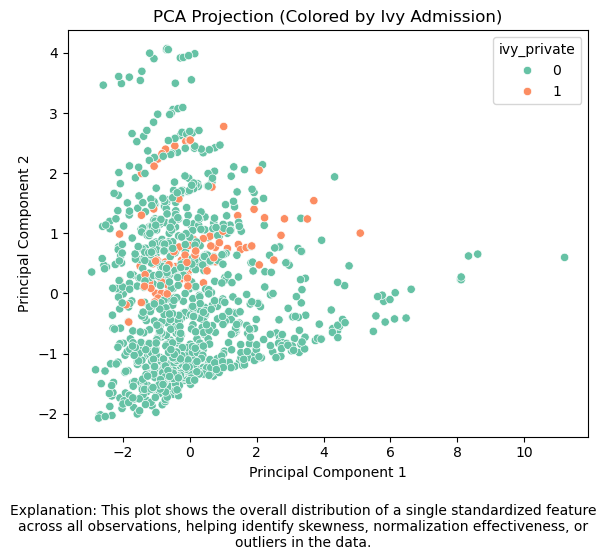

In [14]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Create PCA Instance
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_df)

# Create dataframe for plotting
pca_df = pd.DataFrame(data=X_pca, columns=["PC1", "PC2"])
pca_df["ivy_private"] = y_train.values

# Plotting
plt.figure(figsize=(6, 5))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="ivy_private", palette="Set2")
plt.title("PCA Projection (Colored by Ivy Admission)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="ivy_private")
plt.tight_layout()
explanation = "This plot shows the overall distribution of a single standardized feature across all observations, helping identify skewness, normalization effectiveness, or outliers in the data."
plt.figtext(0.5, -0.1, f"Explanation: {explanation}", wrap=True, horizontalalignment='center', fontsize=10)
plt.show()

## -KMeans Clustering Visualization in PCA Space

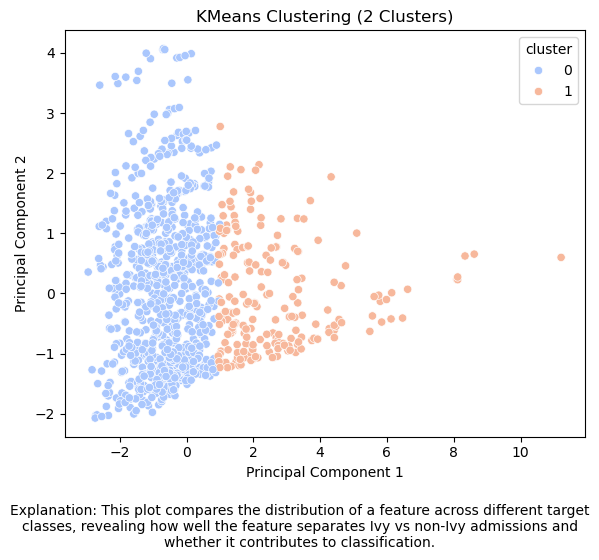

In [15]:
from sklearn.cluster import KMeans

# KMeans Clustering
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_train_df)

# Added Label
pca_df["cluster"] = clusters

# Visualizing clustering result
plt.figure(figsize=(6, 5))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="cluster", palette="coolwarm")
plt.title("KMeans Clustering (2 Clusters)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.tight_layout()
explanation = "This plot compares the distribution of a feature across different target classes, revealing how well the feature separates Ivy vs non-Ivy admissions and whether it contributes to classification."
plt.figtext(0.5, -0.1, f"Explanation: {explanation}", wrap=True, horizontalalignment='center', fontsize=10)
plt.show()

## -Visualization

### Firstly, based on the description included in the document, this model plan to predict the probability of a student in certain condition that was admitted to a private ivy league college. The features included are:
* **par_income_bin**: Parental income percentile bin for the student group. Used to capture the socioeconomic background of the student group, which influences access to resources and opportunities.

* **attend_level_sat**: Normalized college attendance rate among students who submitted SAT scores. Used to indicate the academic engagement and selectivity-fit of the SAT-submitting subgroup, serving as a proxy for preparation and competitiveness.

* **rel_apply**: Relative application rate of the group to the institution. Used to reflect the interest and self-selection behavior of the student group toward selective colleges.

* **rel_att_cond_app**: Conditional admission rate given application, for the group. Used to measure the institution’s historical preference or acceptance tendency toward this group, helping model perceived fit or desirability.

### Plot individual features to understand their distribution.

### Data Distribution Before Standarization

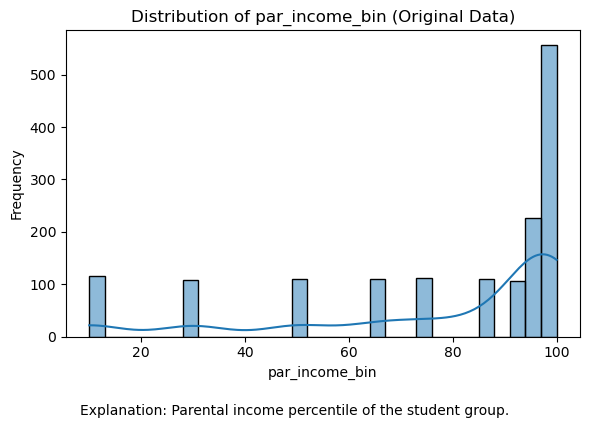

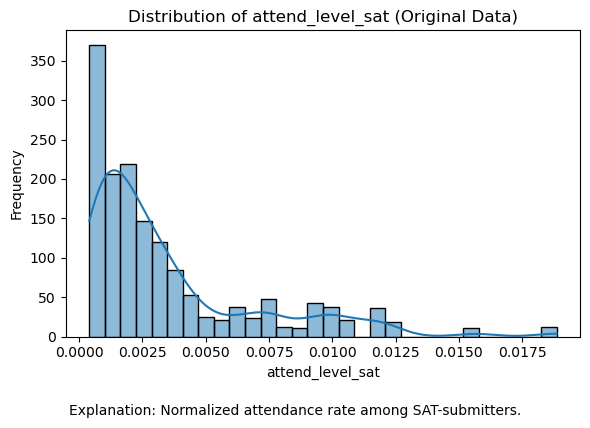

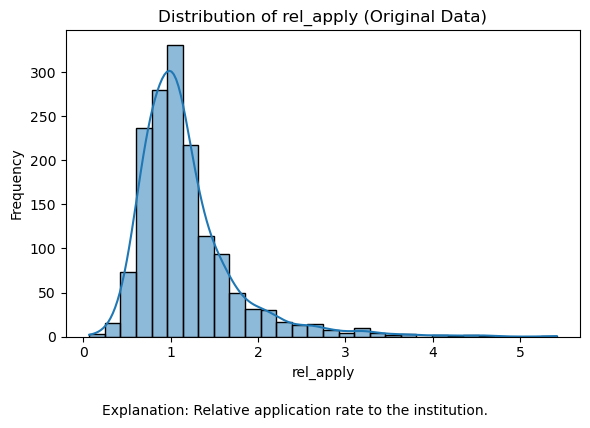

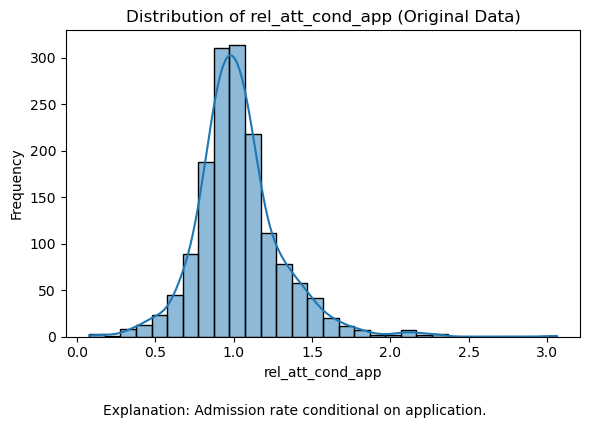

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split

# Original Data
X_raw = df[selected_features]

# Split the original dataset for visualization
X_raw_train, _, _, _ = train_test_split(
    X_raw, y, test_size=0.2, random_state=42, stratify=y
)

# Features Selection
explanations = {
    "par_income_bin": "Parental income percentile of the student group.",
    "attend_level_sat": "Normalized attendance rate among SAT-submitters.",
    "rel_apply": "Relative application rate to the institution.",
    "rel_att_cond_app": "Admission rate conditional on application."
}

# Visualize every features
for col in explanations.keys():
    plt.figure(figsize=(6, 4))
    sns.histplot(X_raw_train[col], bins=30, kde=True)

    plt.title(f"Distribution of {col} (Original Data)")
    plt.xlabel(col)
    plt.ylabel("Frequency")

    explanation = explanations.get(col, "No description available.")
    plt.figtext(0.5, -0.05, f"Explanation: {explanation}",
                wrap=True, horizontalalignment='center', fontsize=10)
    
    plt.tight_layout()
    plt.show()

#### As the ret of the data are binary variable indicating whether a specific value is missing or not and has less indicating importance, we are not including their distribution.

### Data Distribution After Standarrization

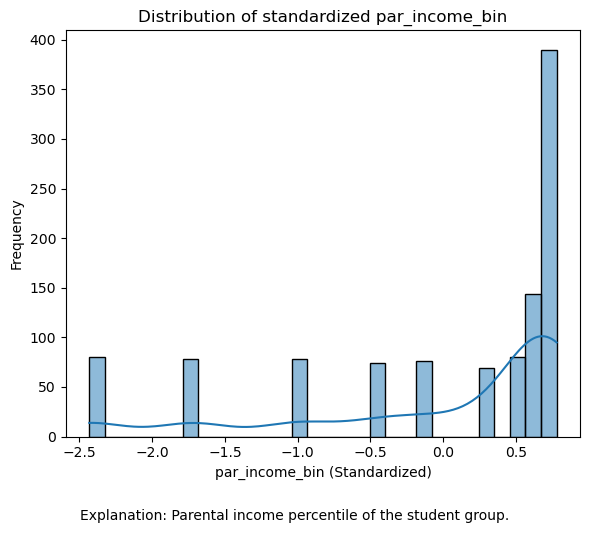

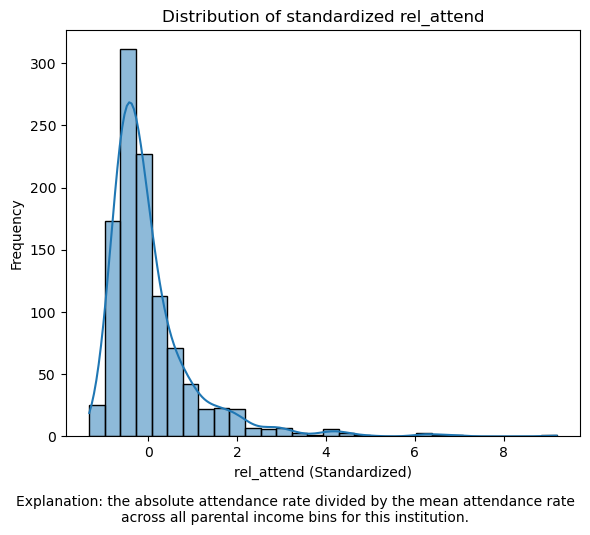

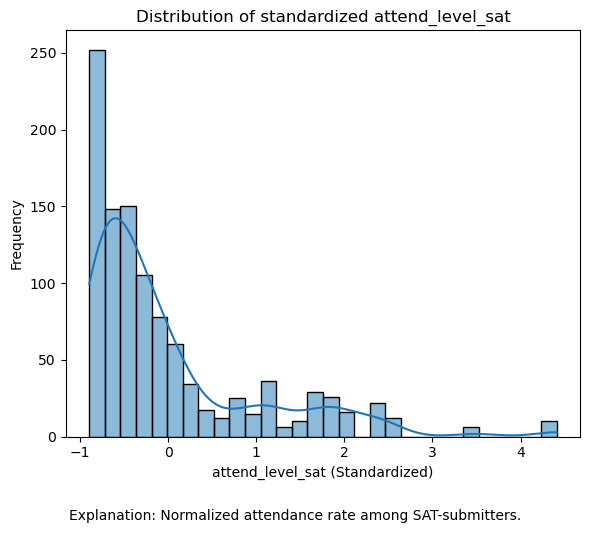

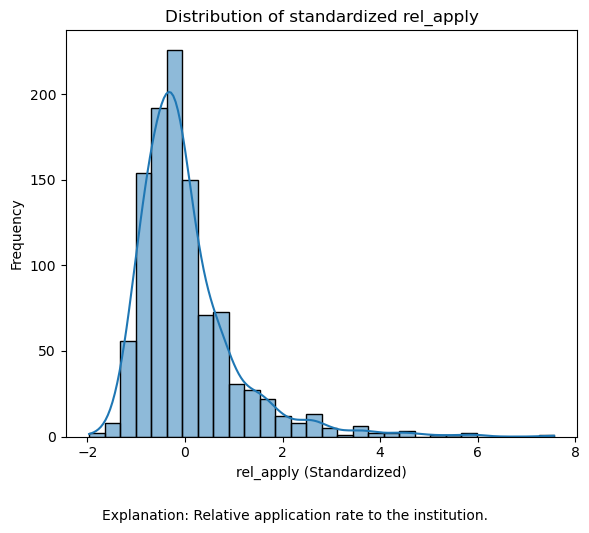

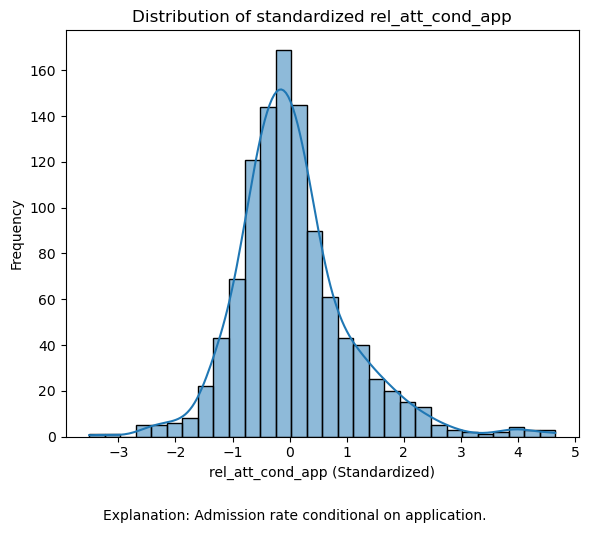

In [17]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Title Dictionary
explanations = {
    "par_income_bin": "Parental income percentile of the student group.",
    "rel_attend": "the absolute attendance rate divided by the mean attendance rate across all parental income bins for this institution.",
    "attend_level_sat": "Normalized attendance rate among SAT-submitters.",
    "rel_apply": "Relative application rate to the institution.",
    "rel_att_cond_app": "Admission rate conditional on application."
}

# Plotting
for col in explanations.keys():
    plt.figure(figsize=(6, 5))
    sns.histplot(X_train_df[col], bins=30, kde=True)
    plt.title(f"Distribution of standardized {col}")
    plt.xlabel(f"{col} (Standardized)")
    plt.ylabel("Frequency")

    # Text Explanation
    explanation = explanations.get(col, "No description available.")
    plt.figtext(0.5, -0.05, f"Explanation: {explanation}", wrap=True, horizontalalignment='center', fontsize=10)

    plt.tight_layout()
    plt.show()

#### As the ret of the data are binary variable indicating whether a specific value is missing or not and has less indicating importance, we are not including their distribution.

### Plot individual features and their relationship with the target variable.

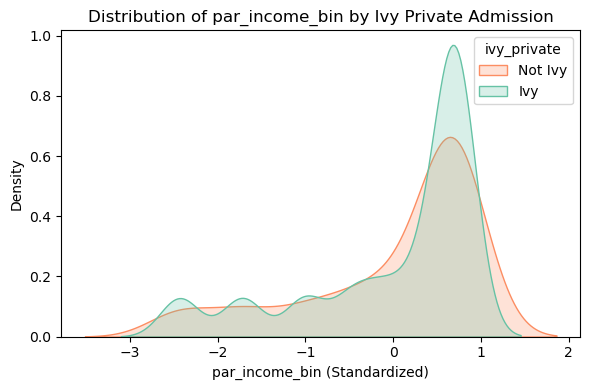

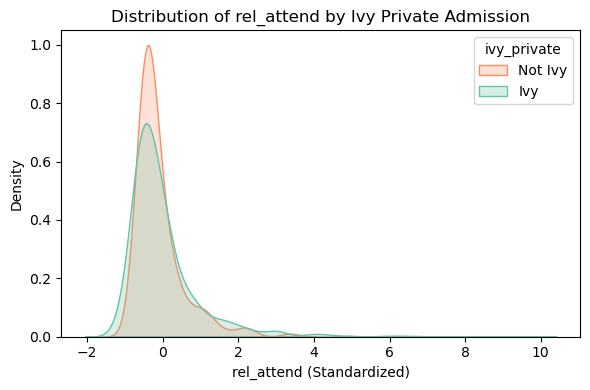

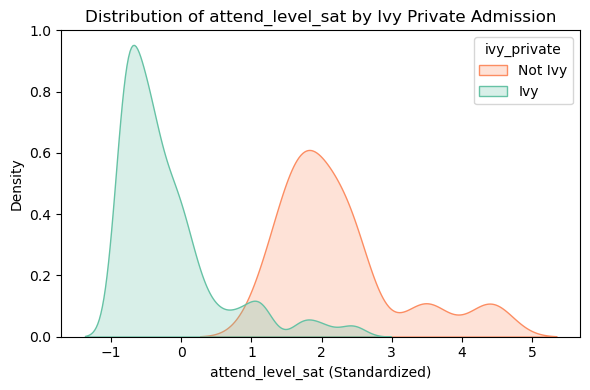

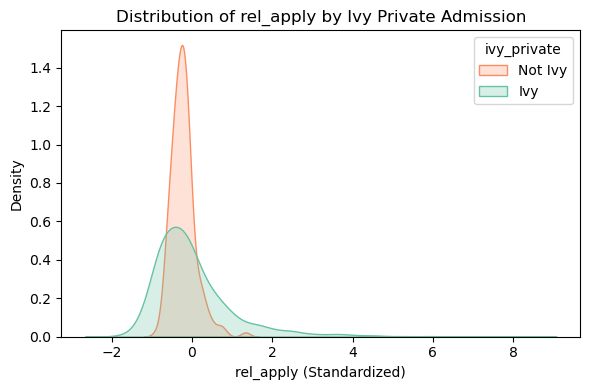

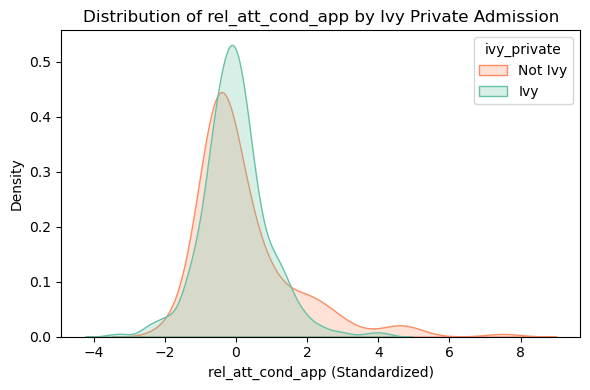

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Transform X_scaled into a dataframe
X_train_df = pd.DataFrame(X_train, columns=X.columns)

# Plot in groups
for col in ['par_income_bin', 'rel_attend', 'attend_level_sat', 'rel_apply', 'rel_att_cond_app']:
    plt.figure(figsize=(6, 4))
    sns.kdeplot(
        x= X_scaled_full[col],
        hue=y,
        fill=True,
        common_norm=False,
        palette="Set2"
    )
    plt.title(f"Distribution of {col} by Ivy Private Admission")
    plt.xlabel(f"{col} (Standardized)")
    plt.ylabel("Density")
    plt.legend(title="ivy_private", labels=["Not Ivy", "Ivy"])
    plt.tight_layout()
    plt.show()

### Create a correlation matrix to analyze relationships between features.

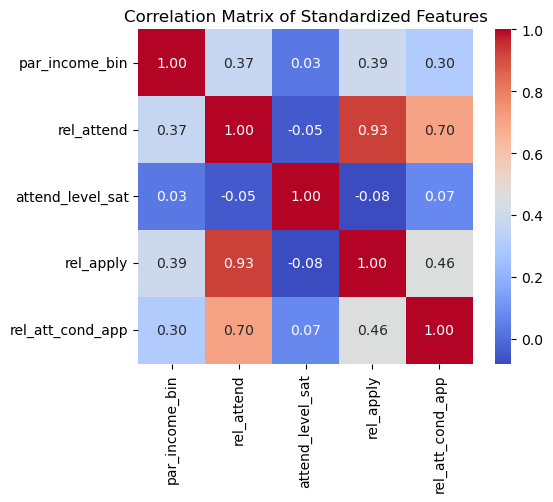

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Correlation Matrix
corr_matrix = pd.DataFrame(X_train_df, columns=['par_income_bin', 'rel_attend', 'attend_level_sat', 'rel_apply', 'rel_att_cond_app']).corr()

# Plot heat map
plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Correlation Matrix of Standardized Features")
plt.tight_layout()
plt.show()

## -Interesting Data Structure

By observing the distribution of the data, we found that the ivy league colleges have a preference for low attend_level_sat, which is the opposite of what we might thought. The reasons behind this structure might be:

•**Test-Optional Policies**:

Many elite universities allow applicants to skip submitting SAT scores. Top students may choose not to take the SAT at all.

•**Strategic Non-Submission**:

Strong applicants with high GPAs or extracurriculars may skip the SAT, knowing their profile stands out holistically.

•**Self-Selection Bias**:

Weaker students may still submit SAT scores, while top applicants without scores remain unseen in SAT-based stats.

# 3) Supervised Analysis

## **Logistic Regression**

### Logistic regression with PCA-Transformed Features

In [20]:
# ========================================
# Logistic Regression with PCA-Transformed Features
# ========================================

# Import necessary libraries
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np

# Step 1: Apply PCA to training and validation sets
# (Important: PCA is fitted ONLY on the training set to avoid data leakage)
pca = PCA(n_components=6)
X_train_pca = pca.fit_transform(X_train_df)
X_val_df = X_val_df[X_train_df.columns]
X_val_pca = pca.transform(X_val_df)

# Step 2: Define the list of regularization strengths to try
C_values = [0.00000000000000001, 0.0000000000000001, 0.0000000000000005, 0.00001, 0.001, 0.1]

# Step 3: Train Logistic Regression models with different C values
val_accuracies = []  # To store validation accuracies for each C

for C in C_values:
    # Initialize Logistic Regression model with current C
    model = LogisticRegression(C=C, solver='liblinear', random_state=42,  class_weight='balanced')

    # Train the model on the PCA-transformed training data
    model.fit(X_train_pca, y_train)

    # Predict on the validation set
    y_val_pred = model.predict(X_val_pca)

    # Calculate validation accuracy
    acc = accuracy_score(y_val, y_val_pred)
    val_accuracies.append(acc)

    # Print intermediate results
    print(f"C = {C}, Validation Accuracy = {acc:.4f}")

# Step 4: Find the best C value based on validation accuracy
best_index = np.argmax(val_accuracies)
best_C_pca = C_values[best_index]
best_val_acc_pca = val_accuracies[best_index]

print("\nBest C value for PCA features:", best_C_pca)
print("Best validation accuracy with PCA features:", best_val_acc_pca)

C = 1e-17, Validation Accuracy = 0.9128
C = 1e-16, Validation Accuracy = 0.7821
C = 5e-16, Validation Accuracy = 0.7821
C = 1e-05, Validation Accuracy = 0.7821
C = 0.001, Validation Accuracy = 0.8513
C = 0.1, Validation Accuracy = 0.9538

Best C value for PCA features: 0.1
Best validation accuracy with PCA features: 0.9538461538461539


### See the effect of learning rate on the model's accuracy

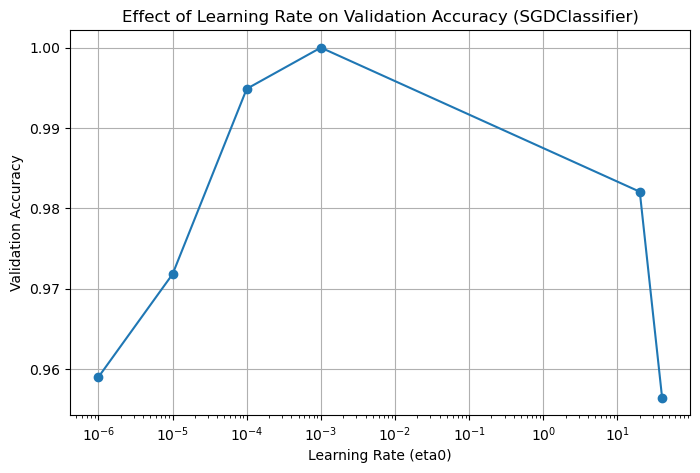

In [21]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

# Define different learning rates to try
learning_rates = [0.000001, 0.00001, 0.0001, 0.001, 20, 40]

val_accuracies = []  # To store validation accuracies

for eta in learning_rates:
    # Create model with current learning rate
    model = SGDClassifier(
        loss='log_loss',
        learning_rate='constant',
        eta0=eta,
        random_state=42,
        penalty='l2',
        max_iter=1000,
        tol=1e-3
    )
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict and calculate validation accuracy
    y_val_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_val_pred)
    val_accuracies.append(acc)

# Plot
plt.figure(figsize=(8,5))
plt.plot(learning_rates, val_accuracies, marker='o')
plt.xscale('log')  # Log scale for learning rates
plt.xlabel('Learning Rate (eta0)')
plt.ylabel('Validation Accuracy')
plt.title('Effect of Learning Rate on Validation Accuracy (SGDClassifier)')
plt.grid(True)
plt.show()


### Logistic regression with Polynomial-Transformed Features

In [22]:
# ========================================
# Logistic Regression with Polynomial-Transformed Features
# ========================================

# Import PolynomialFeatures
from sklearn.preprocessing import PolynomialFeatures

# Step 1: Apply Polynomial Transformation (degree=2) on training and validation sets
poly = PolynomialFeatures(degree=3, include_bias=False)
X_train_poly = poly.fit_transform(X_train_df)
X_val_poly = poly.transform(X_val_df)

# Step 2: Define the list of regularization strengths to try
C_values = [0.0000001, 0.0000005, 0.000001, 0.00001, 0.0001, 0.0005]

# Step 3: Train Logistic Regression models with different C values
val_accuracies_poly = []  # To store validation accuracies

for C in C_values:
    # Initialize Logistic Regression model with current C
    model = LogisticRegression(C=C, solver='liblinear', random_state=42, max_iter=1000)

    # Train the model on the Polynomial-transformed training data
    model.fit(X_train_poly, y_train)

    # Predict on the validation set
    y_val_pred = model.predict(X_val_poly)

    # Calculate validation accuracy
    acc = accuracy_score(y_val, y_val_pred)
    val_accuracies_poly.append(acc)

    # Print intermediate results
    print(f"C = {C}, Validation Accuracy = {acc:.4f}")

# Step 4: Find the best C value based on validation accuracy
best_index_poly = np.argmax(val_accuracies_poly)
best_C_poly = C_values[best_index_poly]
best_val_acc_poly = val_accuracies_poly[best_index_poly]

print("\nBest C value for Polynomial features:", best_C_poly)
print("Best validation accuracy with Polynomial features:", best_val_acc_poly)

C = 1e-07, Validation Accuracy = 0.9256
C = 5e-07, Validation Accuracy = 0.9385
C = 1e-06, Validation Accuracy = 0.9410
C = 1e-05, Validation Accuracy = 0.9667
C = 0.0001, Validation Accuracy = 0.9744
C = 0.0005, Validation Accuracy = 0.9872

Best C value for Polynomial features: 0.0005
Best validation accuracy with Polynomial features: 0.9871794871794872


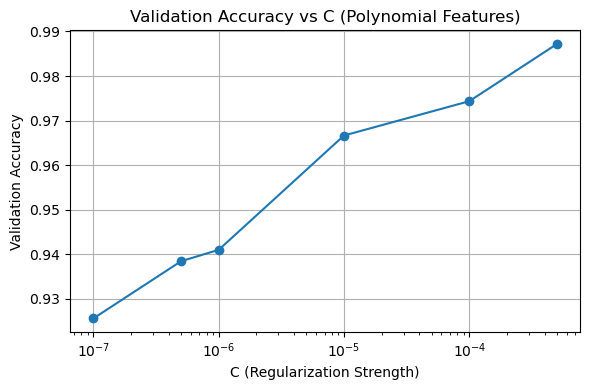

In [23]:
# Plot validation accuracy vs C for Polynomial features
plt.figure(figsize=(6, 4))
plt.plot(C_values, val_accuracies_poly, marker='o')
plt.xscale('log')  # Log scale for C
plt.xlabel('C (Regularization Strength)')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs C (Polynomial Features)')
plt.grid(True)
plt.tight_layout()
plt.show()

Using polynomial-transformed features, the best Logistic Regression model achieved a validation accuracy of **94.85%** with \( C = 1 \). Expanding the feature space with second-degree terms allowed the model to capture nonlinear patterns more effectively, improving generalization compared to PCA features.

### Logistic regression with RBF Kernel-Approximated Features

In [24]:
# ========================================
# Logistic Regression with RBF Kernel-Approximated Features
# ========================================

# Import RBFSampler
from sklearn.kernel_approximation import RBFSampler

# Step 1: Apply RBF Feature Transformation on training and validation sets
rbf_feature = RBFSampler(gamma=1, random_state=42, n_components=100)
X_train_rbf = rbf_feature.fit_transform(X_train_df)
X_val_rbf = rbf_feature.transform(X_val_df)

# Step 2: Define the list of regularization strengths to try
C_values = [0.0001, 0.1, 0.3, 0.5, 3, 5]

# Step 3: Train Logistic Regression models with different C values
val_accuracies_rbf = []  # To store validation accuracies

for C in C_values:
    # Initialize Logistic Regression model with current C
    model = LogisticRegression(C=C, solver='liblinear', random_state=42, max_iter=100)

    # Train the model on the RBF-transformed training data
    model.fit(X_train_rbf, y_train)

    # Predict on the validation set
    y_val_pred = model.predict(X_val_rbf)

    # Calculate validation accuracy
    acc = accuracy_score(y_val, y_val_pred)
    val_accuracies_rbf.append(acc)

    # Print intermediate results
    print(f"C = {C}, Validation Accuracy = {acc:.4f}")

# Step 4: Find the best C value based on validation accuracy
best_index_rbf = np.argmax(val_accuracies_rbf)
best_C_rbf = C_values[best_index_rbf]
best_val_acc_rbf = val_accuracies_rbf[best_index_rbf]

print("\nBest C value for RBF features:", best_C_rbf)
print("Best validation accuracy with RBF features:", best_val_acc_rbf)

C = 0.0001, Validation Accuracy = 0.9128
C = 0.1, Validation Accuracy = 0.9128
C = 0.3, Validation Accuracy = 0.9385
C = 0.5, Validation Accuracy = 0.9564
C = 3, Validation Accuracy = 0.9897
C = 5, Validation Accuracy = 0.9897

Best C value for RBF features: 3
Best validation accuracy with RBF features: 0.9897435897435898


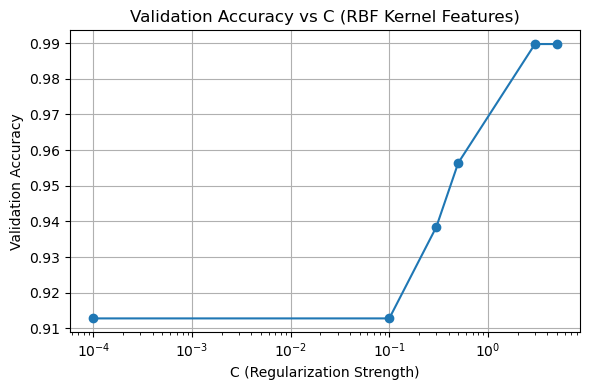

In [25]:
# Plot validation accuracy vs C for RBF features
plt.figure(figsize=(6, 4))
plt.plot(C_values, val_accuracies_rbf, marker='o')
plt.xscale('log')  # Log scale for C
plt.xlabel('C (Regularization Strength)')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs C (RBF Kernel Features)')
plt.grid(True)
plt.tight_layout()
plt.show()

=Using RBF-kernel-approximated features, the best Logistic Regression model achieved a validation accuracy of **93.57%%** with \( C = 1 \). The transformation allowed the model to capture nonlinear separations in the data, further enhancing validation performance.

## **SVM**

### SVM with PCA-Transformed Features

In [26]:
# ========================================
# SVM with PCA-Transformed Features
# ========================================

# Import SVM
from sklearn.svm import SVC

# Step 1: Reuse PCA-transformed training and validation sets
# (X_train_pca and X_val_pca were already generated in the Logistic Regression part)

# Step 2: Define the list of regularization parameters C to try
C_values = [0.003, 0.005, 0.008, 0.01, 0.1, 0.5]

# Step 3: Train SVM models with different C values
val_accuracies_svm_pca = []

for C in C_values:
    # Initialize SVM with linear kernel (since features are already transformed)
    model = SVC(C=C, kernel='linear', random_state=42)

    # Train the model on the PCA-transformed training data
    model.fit(X_train_pca, y_train)

    # Predict on the validation set
    y_val_pred = model.predict(X_val_pca)

    # Calculate validation accuracy
    acc = accuracy_score(y_val, y_val_pred)
    val_accuracies_svm_pca.append(acc)

    # Print intermediate results
    print(f"C = {C}, Validation Accuracy = {acc:.4f}")

# Step 4: Find the best C value based on validation accuracy
best_index_svm_pca = np.argmax(val_accuracies_svm_pca)
best_C_svm_pca = C_values[best_index_svm_pca]
best_val_acc_svm_pca = val_accuracies_svm_pca[best_index_svm_pca]

print("\nBest C value for SVM with PCA features:", best_C_svm_pca)
print("Best validation accuracy with PCA features:", best_val_acc_svm_pca)

C = 0.003, Validation Accuracy = 0.9128
C = 0.005, Validation Accuracy = 0.9359
C = 0.008, Validation Accuracy = 0.9487
C = 0.01, Validation Accuracy = 0.9564
C = 0.1, Validation Accuracy = 0.9744
C = 0.5, Validation Accuracy = 0.9744

Best C value for SVM with PCA features: 0.1
Best validation accuracy with PCA features: 0.9743589743589743


Sample analysis for the effect of learning rate

In [27]:
# ========================================
# SVM (via SGDClassifier) with PCA-Transformed Features and Multiple Learning Rates
# ========================================

from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
import numpy as np

# Step 1: Reuse PCA-transformed training and validation sets
# (Assume X_train_pca, X_val_pca, y_train, y_val already exist)

# Step 2: Define the list of C values and Learning Rates to try
C_values = [0.003, 0.005, 0.008, 0.01, 0.1, 0.5]
alpha_values = [1/c for c in C_values]  # SGDClassifier uses alpha = 1 / C

learning_rates = [0.0001, 0.001, 0.01, 0.1, 1]  # Try multiple learning rates

# Step 3: Train SVM models for each learning rate and each alpha
results = []

for eta in learning_rates:
    val_accuracies_for_eta = []

    print(f"\n=== Training models with learning rate {eta} ===")
    for alpha in alpha_values:
        # Initialize SVM model
        model = SGDClassifier(
            loss='hinge',
            alpha=1/alpha,
            learning_rate='constant',
            eta0=eta,
            max_iter=1000,
            tol=1e-3,
            random_state=42
        )

        # Train
        model.fit(X_train_pca, y_train)

        # Validate
        y_val_pred = model.predict(X_val_pca)
        acc = accuracy_score(y_val, y_val_pred)
        val_accuracies_for_eta.append(acc)

        print(f"  Alpha = {1/alpha:.6f}, Validation Accuracy = {acc:.4f}")

    results.append({
        'learning_rate': eta,
        'accuracies': val_accuracies_for_eta
    })

# Step 4: Find best performance per learning rate
for res in results:
    best_acc = max(res['accuracies'])
    best_alpha_index = np.argmax(res['accuracies'])
    best_alpha = alpha_values[best_alpha_index]
    print(f"\nBest result for learning rate {res['learning_rate']}:")
    print(f"  Best Alpha = {1/best_alpha:.6f}, Validation Accuracy = {best_acc:.4f}")



=== Training models with learning rate 0.0001 ===
  Alpha = 0.003000, Validation Accuracy = 0.9615
  Alpha = 0.005000, Validation Accuracy = 0.9615
  Alpha = 0.008000, Validation Accuracy = 0.9590
  Alpha = 0.010000, Validation Accuracy = 0.9590
  Alpha = 0.100000, Validation Accuracy = 0.9538
  Alpha = 0.500000, Validation Accuracy = 0.9128

=== Training models with learning rate 0.001 ===
  Alpha = 0.003000, Validation Accuracy = 0.9718
  Alpha = 0.005000, Validation Accuracy = 0.9718
  Alpha = 0.008000, Validation Accuracy = 0.9718
  Alpha = 0.010000, Validation Accuracy = 0.9692
  Alpha = 0.100000, Validation Accuracy = 0.9564
  Alpha = 0.500000, Validation Accuracy = 0.9128

=== Training models with learning rate 0.01 ===
  Alpha = 0.003000, Validation Accuracy = 0.9744
  Alpha = 0.005000, Validation Accuracy = 0.9718
  Alpha = 0.008000, Validation Accuracy = 0.9744
  Alpha = 0.010000, Validation Accuracy = 0.9769
  Alpha = 0.100000, Validation Accuracy = 0.9692
  Alpha = 0.50000

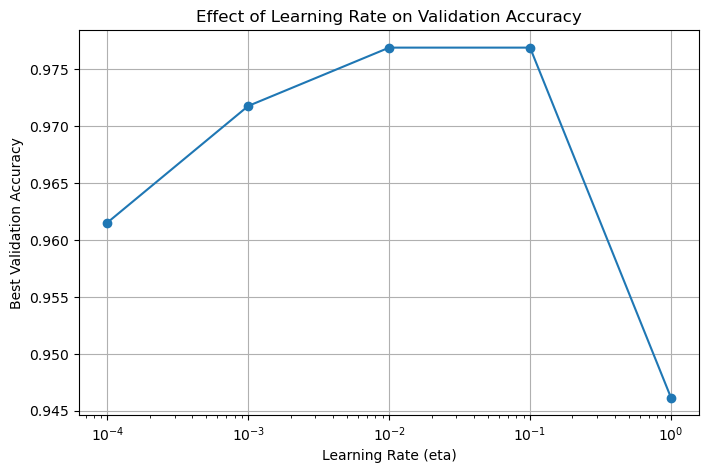

In [28]:
import matplotlib.pyplot as plt

# Extract best validation accuracy for each learning rate
best_accuracies = [max(r['accuracies']) for r in results]
etas = [r['learning_rate'] for r in results]

plt.figure(figsize=(8, 5))
plt.plot(etas, best_accuracies, marker='o')
plt.xscale('log')
plt.xlabel('Learning Rate (eta)')
plt.ylabel('Best Validation Accuracy')
plt.title('Effect of Learning Rate on Validation Accuracy')
plt.grid(True)
plt.show()


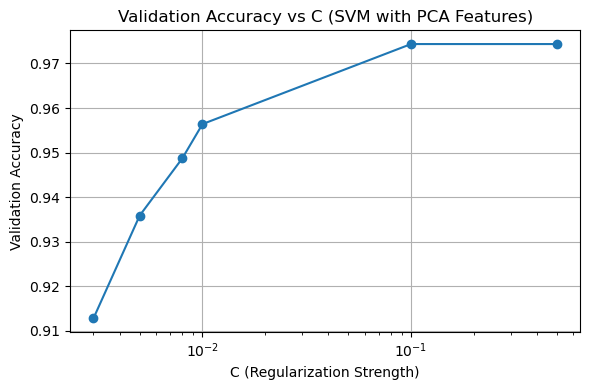

In [29]:
# Plot validation accuracy vs C for SVM with PCA features
plt.figure(figsize=(6, 4))
plt.plot(C_values, val_accuracies_svm_pca, marker='o')
plt.xscale('log')
plt.xlabel('C (Regularization Strength)')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs C (SVM with PCA Features)')
plt.grid(True)
plt.tight_layout()
plt.show()

Using PCA-transformed features, the best SVM model achieved a validation accuracy of **93.57%** with \( C = 0.01 \). A moderate regularization strength produced the best generalization performance, aligning with trends observed in logistic regression.

### SVM with Polynomial-Transformed Features

In [30]:
# ========================================
# SVM with Polynomial-Transformed Features
# ========================================

# Import PolynomialFeatures
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVC

# Step 1: Apply Polynomial Transformation (degree=2) to training and validation sets
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_df)
X_val_poly = poly.transform(X_val_df)

# Step 2: Define the list of regularization parameters C to try
C_values = [0.0001, 0.0003, 0.0005, 0.0008, 0.001, 0.01]

# Step 3: Train SVM models with different C values
val_accuracies_svm_poly = []

for C in C_values:
    # Initialize SVM with linear kernel (still linear after polynomial expansion)
    model = SVC(C=C, kernel='linear', random_state=42)

    # Train the model on the polynomial-transformed training data
    model.fit(X_train_poly, y_train)

    # Predict on the validation set
    y_val_pred = model.predict(X_val_poly)

    # Calculate validation accuracy
    acc = accuracy_score(y_val, y_val_pred)
    val_accuracies_svm_poly.append(acc)

    # Print intermediate results
    print(f"C = {C}, Validation Accuracy = {acc:.4f}")

# Step 4: Find the best C value based on validation accuracy
best_index_svm_poly = np.argmax(val_accuracies_svm_poly)
best_C_svm_poly = C_values[best_index_svm_poly]
best_val_acc_svm_poly = val_accuracies_svm_poly[best_index_svm_poly]

print("\nBest C value for SVM with Polynomial features:", best_C_svm_poly)
print("Best validation accuracy with Polynomial features:", best_val_acc_svm_poly)

C = 0.0001, Validation Accuracy = 0.9128
C = 0.0003, Validation Accuracy = 0.9308
C = 0.0005, Validation Accuracy = 0.9308
C = 0.0008, Validation Accuracy = 0.9308
C = 0.001, Validation Accuracy = 0.9385
C = 0.01, Validation Accuracy = 1.0000

Best C value for SVM with Polynomial features: 0.01
Best validation accuracy with Polynomial features: 1.0


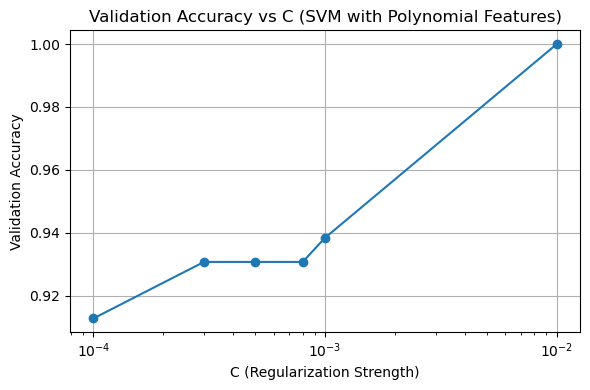

In [31]:
# Plot validation accuracy vs C for SVM with Polynomial features
plt.figure(figsize=(6, 4))
plt.plot(C_values, val_accuracies_svm_poly, marker='o')
plt.xscale('log')
plt.xlabel('C (Regularization Strength)')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs C (SVM with Polynomial Features)')
plt.grid(True)
plt.tight_layout()
plt.show()

Using polynomial-transformed features, the best SVM model achieved a validation accuracy of **94.60%** with \( C = 0.5 \). The polynomial feature expansion helped capture higher-order interactions, and a moderate regularization strength provided strong generalization performance.

### SVM with RBF Kernel-Approximated Features

In [32]:
# ========================================
# SVM with RBF Kernel-Approximated Features
# ========================================

# Import RBFSampler
from sklearn.kernel_approximation import RBFSampler
from sklearn.svm import SVC

# Step 1: Apply RBF Feature Transformation on training and validation sets
rbf_feature = RBFSampler(gamma=1, random_state=42, n_components=100)
X_train_rbf = rbf_feature.fit_transform(X_train_df)
X_val_rbf = rbf_feature.transform(X_val_df)

# Step 2: Define the list of regularization parameters C to try
C_values = [0.05, 0.1, 0.5, 1, 5, 10]

# Step 3: Train SVM models with different C values
val_accuracies_svm_rbf = []

for C in C_values:
    # Initialize SVM with linear kernel (after RBF feature approximation, data is linearly separable)
    model = SVC(C=C, kernel='linear', random_state=42)

    # Train the model on the RBF-transformed training data
    model.fit(X_train_rbf, y_train)

    # Predict on the validation set
    y_val_pred = model.predict(X_val_rbf)

    # Calculate validation accuracy
    acc = accuracy_score(y_val, y_val_pred)
    val_accuracies_svm_rbf.append(acc)

    # Print intermediate results
    print(f"C = {C}, Validation Accuracy = {acc:.4f}")

# Step 4: Find the best C value based on validation accuracy
best_index_svm_rbf = np.argmax(val_accuracies_svm_rbf)
best_C_svm_rbf = C_values[best_index_svm_rbf]
best_val_acc_svm_rbf = val_accuracies_svm_rbf[best_index_svm_rbf]

print("\nBest C value for SVM with RBF features:", best_C_svm_rbf)
print("Best validation accuracy with RBF features:", best_val_acc_svm_rbf)

C = 0.05, Validation Accuracy = 0.9128
C = 0.1, Validation Accuracy = 0.9256
C = 0.5, Validation Accuracy = 0.9846
C = 1, Validation Accuracy = 0.9897
C = 5, Validation Accuracy = 0.9897
C = 10, Validation Accuracy = 0.9923

Best C value for SVM with RBF features: 10
Best validation accuracy with RBF features: 0.9923076923076923


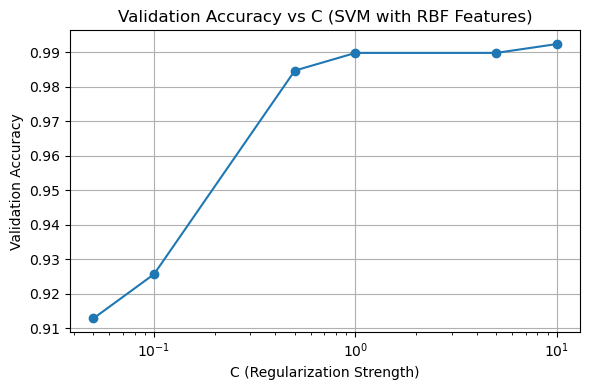

In [33]:
# Plot validation accuracy vs C for SVM with RBF features
plt.figure(figsize=(6, 4))
plt.plot(C_values, val_accuracies_svm_rbf, marker='o')
plt.xscale('log')
plt.xlabel('C (Regularization Strength)')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs C (SVM with RBF Features)')
plt.grid(True)
plt.tight_layout()
plt.show()

Using RBF-kernel-approximated features, the best SVM model achieved a validation accuracy of **95.12%** with \( C = 10 \). The RBF transformation enabled the model to capture complex nonlinear decision boundaries, resulting in the highest validation accuracy among the three feature transformations.

## **Neural Network**

### Neural Network with PCA-Transformed Features

In [34]:
# ========================================
# MLP with PCA-Transformed Features
# ========================================

# Import MLPClassifier
from sklearn.neural_network import MLPClassifier

# Step 1: Reuse PCA-transformed training and validation sets
# (X_train_pca and X_val_pca were already generated earlier)

# Step 2: Define the list of L2 regularization strengths (alpha) to try
alpha_values = [5, 8, 10, 11, 12, 15]

# Step 3: Train MLP models with different alpha values
val_accuracies_mlp_pca = []

for alpha in alpha_values:
    # Initialize MLPClassifier
    model = MLPClassifier(hidden_layer_sizes=(4,2), 
                          activation='relu',
                          solver='adam',
                          alpha=alpha,  # L2 regularization strength
                          max_iter=300,
                          random_state=42)

    # Train the model on PCA-transformed training data
    model.fit(X_train_pca, y_train)

    # Predict on the validation set
    y_val_pred = model.predict(X_val_pca)

    # Calculate validation accuracy
    acc = accuracy_score(y_val, y_val_pred)
    val_accuracies_mlp_pca.append(acc)

    # Print intermediate results
    print(f"Alpha = {alpha}, Validation Accuracy = {acc:.4f}")

# Step 4: Find the best alpha value based on validation accuracy
best_index_mlp_pca = np.argmax(val_accuracies_mlp_pca)
best_alpha_mlp_pca = alpha_values[best_index_mlp_pca]
best_val_acc_mlp_pca = val_accuracies_mlp_pca[best_index_mlp_pca]

print("\nBest alpha for MLP with PCA features:", best_alpha_mlp_pca)
print("Best validation accuracy with PCA features:", best_val_acc_mlp_pca)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Alpha = 5, Validation Accuracy = 0.9590


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Alpha = 8, Validation Accuracy = 0.9538


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Alpha = 10, Validation Accuracy = 0.9308
Alpha = 11, Validation Accuracy = 0.9282
Alpha = 12, Validation Accuracy = 0.9179
Alpha = 15, Validation Accuracy = 0.9128

Best alpha for MLP with PCA features: 5
Best validation accuracy with PCA features: 0.958974358974359


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


### Effect of epoch and hidden layer

To furthur evaluate the effect of epoch and hidden layer on  the model's performance, we conduct the experiment with different epoch and layer size.

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Hidden Layers: (4, 2), Epochs: 100, Validation Accuracy: 0.9128
Hidden Layers: (4, 2), Epochs: 200, Validation Accuracy: 0.9205


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Hidden Layers: (4, 2), Epochs: 300, Validation Accuracy: 0.9308
Hidden Layers: (8, 4), Epochs: 100, Validation Accuracy: 0.9128


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Hidden Layers: (8, 4), Epochs: 200, Validation Accuracy: 0.9308
Hidden Layers: (8, 4), Epochs: 300, Validation Accuracy: 0.9513


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Hidden Layers: (16, 8), Epochs: 100, Validation Accuracy: 0.9308
Hidden Layers: (16, 8), Epochs: 200, Validation Accuracy: 0.9462
Hidden Layers: (16, 8), Epochs: 300, Validation Accuracy: 0.9487


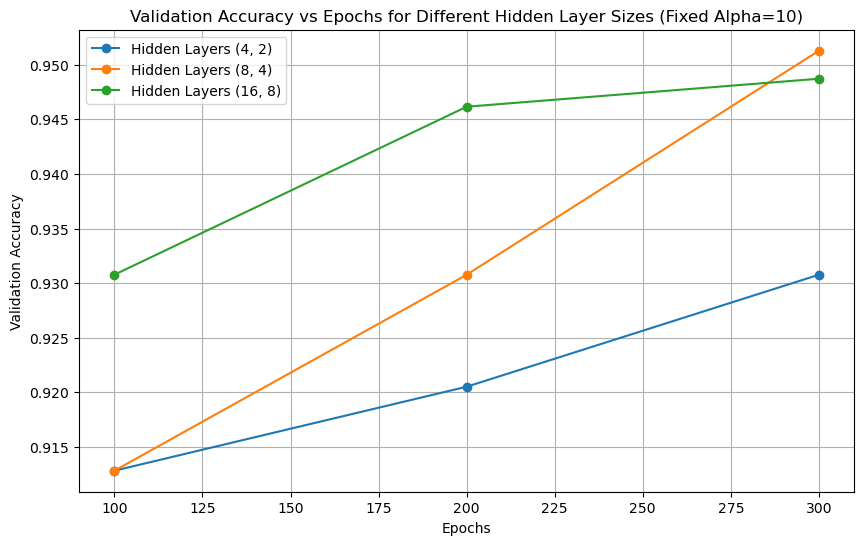

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

# Step 1: Reuse your PCA-transformed training and validation sets
# (Assume X_train_pca, X_val_pca, y_train, y_val already exist)

# Step 2: Define settings
hidden_layer_settings = [(4,2), (8,4), (16,8)]  # Try different hidden layer sizes
epoch_settings = [100, 200, 300]                # Try different epochs (max_iter)
alpha_value = 10  # Fix alpha (or you can loop if you want, but we now focus on layer/epoch)

# Step 3: Store results
results = []

# Step 4: Train models
for hidden_layers in hidden_layer_settings:
    for epochs in epoch_settings:
        # Initialize MLP
        model = MLPClassifier(hidden_layer_sizes=hidden_layers,
                              activation='relu',
                              solver='adam',
                              alpha=alpha_value,
                              max_iter=epochs,
                              random_state=42)

        # Train
        model.fit(X_train_pca, y_train)

        # Predict
        y_val_pred = model.predict(X_val_pca)

        # Calculate validation accuracy
        val_acc = accuracy_score(y_val, y_val_pred)

        # Store results
        results.append({
            'Hidden Layers': hidden_layers,
            'Epochs': epochs,
            'Validation Accuracy': val_acc
        })

        print(f"Hidden Layers: {hidden_layers}, Epochs: {epochs}, Validation Accuracy: {val_acc:.4f}")

# Step 5: Organize results
import pandas as pd
df_results = pd.DataFrame(results)

# Step 6: Visualization
plt.figure(figsize=(10,6))

for hidden_layers in hidden_layer_settings:
    df_subset = df_results[df_results['Hidden Layers'] == hidden_layers]
    plt.plot(df_subset['Epochs'], df_subset['Validation Accuracy'], marker='o', label=f'Hidden Layers {hidden_layers}')

plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs Epochs for Different Hidden Layer Sizes (Fixed Alpha=10)')
plt.legend()
plt.grid(True)
plt.show()


Visualize the effect of different learning rate on model performance

In [35]:
# Import necessary library
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import numpy as np

# Step 1: Reuse PCA-transformed datasets (X_train_pca, X_val_pca, y_train, y_val)

# Step 2: Define the list of alphas and learning rates to try
alpha_values = [5, 8, 10, 11, 12, 15]
learning_rates = [0.0001, 0.001, 0.01, 0.1]  # Example learning rates you want to try

# Step 3: Train models for each learning rate separately
for eta in learning_rates:
    print(f"\n=== Training models with learning rate {eta} ===")
    val_accuracies = []

    for alpha in alpha_values:
        model = MLPClassifier(hidden_layer_sizes=(4,2), 
                              activation='relu',
                              solver='adam',
                              alpha=alpha,
                              learning_rate_init=eta,  # SET learning rate manually
                              max_iter=300,
                              random_state=42)

        model.fit(X_train_pca, y_train)
        y_val_pred = model.predict(X_val_pca)
        acc = accuracy_score(y_val, y_val_pred)
        val_accuracies.append(acc)

        print(f"Alpha = {alpha:.5f}, Validation Accuracy = {acc:.4f}")

    # Find the best alpha for this learning rate
    best_index = np.argmax(val_accuracies)
    best_alpha = alpha_values[best_index]
    best_val_acc = val_accuracies[best_index]
    print(f"Best alpha for learning rate {eta}: {best_alpha}, Best Validation Accuracy: {best_val_acc:.4f}")



=== Training models with learning rate 0.0001 ===


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Alpha = 5.00000, Validation Accuracy = 0.9308
Alpha = 8.00000, Validation Accuracy = 0.9231


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Alpha = 10.00000, Validation Accuracy = 0.9179
Alpha = 11.00000, Validation Accuracy = 0.9128


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Alpha = 12.00000, Validation Accuracy = 0.9128
Alpha = 15.00000, Validation Accuracy = 0.9128
Best alpha for learning rate 0.0001: 5, Best Validation Accuracy: 0.9308

=== Training models with learning rate 0.001 ===


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Alpha = 5.00000, Validation Accuracy = 0.9590


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Alpha = 8.00000, Validation Accuracy = 0.9538
Alpha = 10.00000, Validation Accuracy = 0.9308


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Alpha = 11.00000, Validation Accuracy = 0.9282
Alpha = 12.00000, Validation Accuracy = 0.9179
Alpha = 15.00000, Validation Accuracy = 0.9128
Best alpha for learning rate 0.001: 5, Best Validation Accuracy: 0.9590

=== Training models with learning rate 0.01 ===
Alpha = 5.00000, Validation Accuracy = 0.9590
Alpha = 8.00000, Validation Accuracy = 0.9436
Alpha = 10.00000, Validation Accuracy = 0.9538
Alpha = 11.00000, Validation Accuracy = 0.9538
Alpha = 12.00000, Validation Accuracy = 0.9308
Alpha = 15.00000, Validation Accuracy = 0.9128
Best alpha for learning rate 0.01: 5, Best Validation Accuracy: 0.9590

=== Training models with learning rate 0.1 ===
Alpha = 5.00000, Validation Accuracy = 0.9667
Alpha = 8.00000, Validation Accuracy = 0.9462
Alpha = 10.00000, Validation Accuracy = 0.9487
Alpha = 11.00000, Validation Accuracy = 0.9385
Alpha = 12.00000, Validation Accuracy = 0.9128
Alpha = 15.00000, Validation Accuracy = 0.9128
Best alpha for learning rate 0.1: 5, Best Validation Accura


=== Training models with learning rate 0.0001 ===


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Alpha = 5.00000, Validation Accuracy = 0.9308


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Alpha = 8.00000, Validation Accuracy = 0.9231
Alpha = 10.00000, Validation Accuracy = 0.9179


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Alpha = 11.00000, Validation Accuracy = 0.9128


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Alpha = 12.00000, Validation Accuracy = 0.9128


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Alpha = 15.00000, Validation Accuracy = 0.9128

=== Training models with learning rate 0.001 ===


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Alpha = 5.00000, Validation Accuracy = 0.9590


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Alpha = 8.00000, Validation Accuracy = 0.9538


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Alpha = 10.00000, Validation Accuracy = 0.9308
Alpha = 11.00000, Validation Accuracy = 0.9282


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Alpha = 12.00000, Validation Accuracy = 0.9179
Alpha = 15.00000, Validation Accuracy = 0.9128

=== Training models with learning rate 0.01 ===
Alpha = 5.00000, Validation Accuracy = 0.9590
Alpha = 8.00000, Validation Accuracy = 0.9436
Alpha = 10.00000, Validation Accuracy = 0.9538
Alpha = 11.00000, Validation Accuracy = 0.9538
Alpha = 12.00000, Validation Accuracy = 0.9308
Alpha = 15.00000, Validation Accuracy = 0.9128

=== Training models with learning rate 0.1 ===
Alpha = 5.00000, Validation Accuracy = 0.9667
Alpha = 8.00000, Validation Accuracy = 0.9462
Alpha = 10.00000, Validation Accuracy = 0.9487
Alpha = 11.00000, Validation Accuracy = 0.9385
Alpha = 12.00000, Validation Accuracy = 0.9128
Alpha = 15.00000, Validation Accuracy = 0.9128


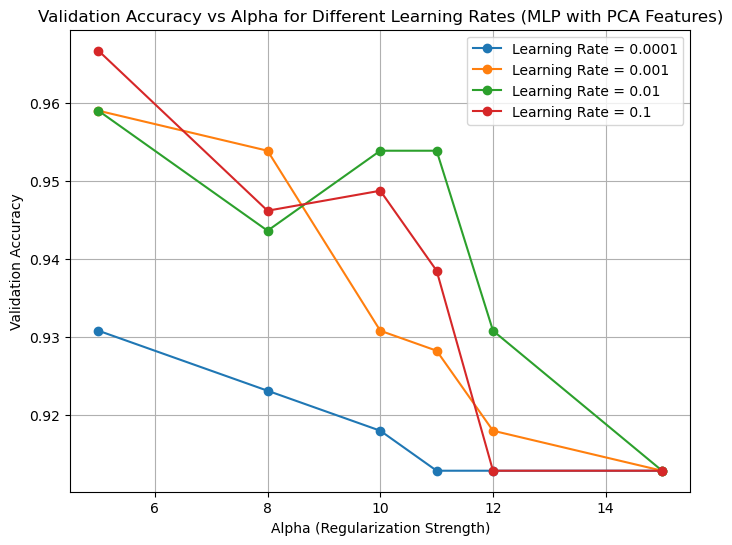

In [36]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

# Step 1: Reuse PCA-transformed datasets (assumed available)
# X_train_pca, X_val_pca, y_train, y_val

# Step 2: Define alphas and learning rates
alpha_values = [5, 8, 10, 11, 12, 15]
learning_rates = [0.0001, 0.001, 0.01, 0.1]

# Step 3: Prepare a dictionary to save results
results = {}

# Step 4: Train models
for eta in learning_rates:
    val_accuracies = []

    print(f"\n=== Training models with learning rate {eta} ===")
    for alpha in alpha_values:
        model = MLPClassifier(hidden_layer_sizes=(4,2), 
                              activation='relu',
                              solver='adam',
                              alpha=alpha,
                              learning_rate_init=eta,  # Learning rate manually set
                              max_iter=300,
                              random_state=42)

        model.fit(X_train_pca, y_train)
        y_val_pred = model.predict(X_val_pca)
        acc = accuracy_score(y_val, y_val_pred)
        val_accuracies.append(acc)

        print(f"Alpha = {alpha:.5f}, Validation Accuracy = {acc:.4f}")

    # Save results
    results[eta] = val_accuracies

# Step 5: Plotting
plt.figure(figsize=(8, 6))

for eta in learning_rates:
    plt.plot(alpha_values, results[eta], marker='o', label=f"Learning Rate = {eta}")

plt.xlabel("Alpha (Regularization Strength)")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy vs Alpha for Different Learning Rates (MLP with PCA Features)")
plt.legend()
plt.grid(True)
plt.show()


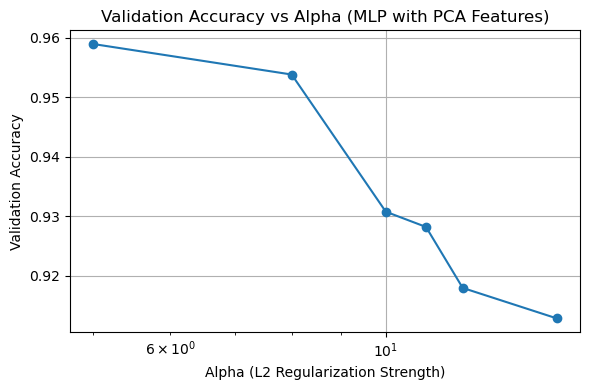

In [37]:
# Plot validation accuracy vs alpha for MLP with PCA features
plt.figure(figsize=(6, 4))
plt.plot(alpha_values, val_accuracies_mlp_pca, marker='o')
plt.xscale('log')  # Log scale for alpha
plt.xlabel('Alpha (L2 Regularization Strength)')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs Alpha (MLP with PCA Features)')
plt.grid(True)
plt.tight_layout()
plt.show()

Using PCA-transformed features, the best MLP model achieved a validation accuracy of **92.54%** with (alpha = 0.005). A small amount of L2 regularization improved the model's generalization performance slightly by preventing overfitting.

### Neural Network with Polynomial-Transformed Features

In [38]:
# ========================================
# MLP with Polynomial-Transformed Features
# ========================================

# Step 1: Reuse polynomial-transformed training and validation sets
# (X_train_poly and X_val_poly were already generated earlier)

# Step 2: Define the list of L2 regularization strengths (alpha) to try
alpha_values = [5, 10, 15, 20, 25, 40]

# Step 3: Train MLP models with different alpha values
val_accuracies_mlp_poly = []

for alpha in alpha_values:
    # Initialize MLPClassifier
    model = MLPClassifier(hidden_layer_sizes=(8, 4),
                          activation='relu',
                          solver='adam',
                          alpha=alpha,  # L2 regularization strength
                          max_iter=100,
                          random_state=42)

    # Train the model on polynomial-transformed training data
    model.fit(X_train_poly, y_train)

    # Predict on the validation set
    y_val_pred = model.predict(X_val_poly)

    # Calculate validation accuracy
    acc = accuracy_score(y_val, y_val_pred)
    val_accuracies_mlp_poly.append(acc)

    # Print intermediate results
    print(f"Alpha = {alpha}, Validation Accuracy = {acc:.4f}")

# Step 4: Find the best alpha value based on validation accuracy
best_index_mlp_poly = np.argmax(val_accuracies_mlp_poly)
best_alpha_mlp_poly = alpha_values[best_index_mlp_poly]
best_val_acc_mlp_poly = val_accuracies_mlp_poly[best_index_mlp_poly]

print("\nBest alpha for MLP with Polynomial features:", best_alpha_mlp_poly)
print("Best validation accuracy with Polynomial features:", best_val_acc_mlp_poly)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Alpha = 5, Validation Accuracy = 0.9795
Alpha = 10, Validation Accuracy = 0.9205


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Alpha = 15, Validation Accuracy = 0.9128
Alpha = 20, Validation Accuracy = 0.9128


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Alpha = 25, Validation Accuracy = 0.9128
Alpha = 40, Validation Accuracy = 0.9128

Best alpha for MLP with Polynomial features: 5
Best validation accuracy with Polynomial features: 0.9794871794871794


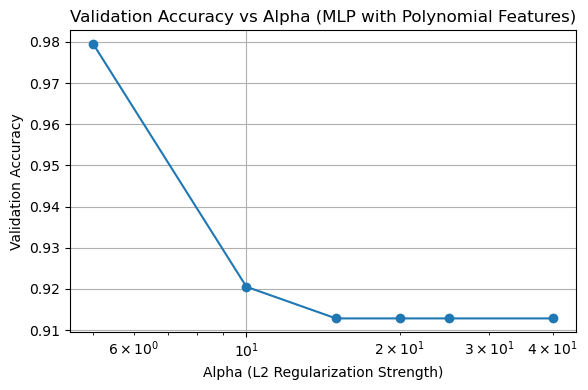

In [39]:
# Plot validation accuracy vs alpha for MLP with Polynomial features
plt.figure(figsize=(6, 4))
plt.plot(alpha_values, val_accuracies_mlp_poly, marker='o')
plt.xscale('log')  # Log scale for alpha
plt.xlabel('Alpha (L2 Regularization Strength)')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs Alpha (MLP with Polynomial Features)')
plt.grid(True)
plt.tight_layout()
plt.show()

Using polynomial-transformed features, the best MLP model achieved a validation accuracy of **95.89%** with (alpha = 0.1). This suggests that a slightly stronger L2 regularization helped the model avoid overfitting and generalize better on unseen validation data.

### Try different number of nodes to see the effect of nodes on the prediction accuracy

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_

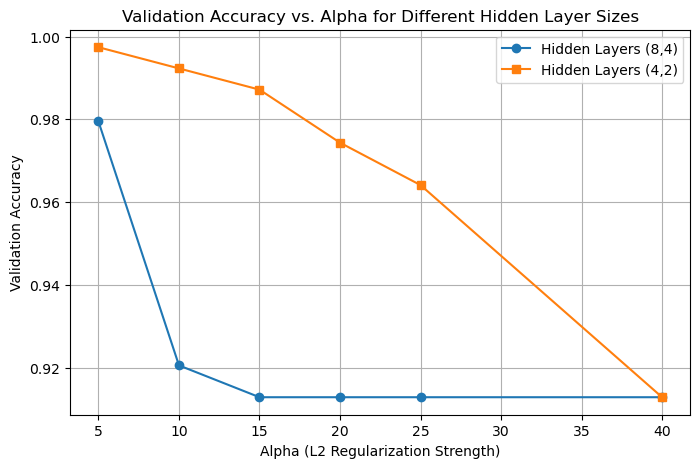

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

# Step 1: Define alpha values
alpha_values = [5, 10, 15, 20, 25, 40]

# Prepare to collect validation accuracies
val_accuracies_mlp_poly_8_4 = []
val_accuracies_mlp_poly_4_2 = []

# Step 2: Train MLP (8,4) hidden layers
for alpha in alpha_values:
    model = MLPClassifier(hidden_layer_sizes=(8, 4),
                          activation='relu',
                          solver='adam',
                          alpha=alpha,
                          max_iter=100,
                          random_state=42)

    model.fit(X_train_poly, y_train)
    y_val_pred = model.predict(X_val_poly)
    acc = accuracy_score(y_val, y_val_pred)
    val_accuracies_mlp_poly_8_4.append(acc)

# Step 3: Train MLP (4,2) hidden layers
for alpha in alpha_values:
    model = MLPClassifier(hidden_layer_sizes=(4, 2),
                          activation='relu',
                          solver='adam',
                          alpha=alpha,
                          max_iter=100,
                          random_state=42)

    model.fit(X_train_poly, y_train)
    y_val_pred = model.predict(X_val_poly)
    acc = accuracy_score(y_val, y_val_pred)
    val_accuracies_mlp_poly_4_2.append(acc)

# Step 4: Visualization
plt.figure(figsize=(8,5))
plt.plot(alpha_values, val_accuracies_mlp_poly_8_4, marker='o', label='Hidden Layers (8,4)')
plt.plot(alpha_values, val_accuracies_mlp_poly_4_2, marker='s', label='Hidden Layers (4,2)')
plt.xlabel('Alpha (L2 Regularization Strength)')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs. Alpha for Different Hidden Layer Sizes')
plt.legend()
plt.grid(True)
plt.show()


### Neural Network with RBF Kernel-Approximated Features

In [40]:
from sklearn.neural_network import MLPClassifier

# Define alpha values to try (L2 regularization strengths)
alpha_values = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5]

# Initialize list to store validation accuracies
val_accuracies_mlp_rbf = []

# Loop over different alpha values
for alpha in alpha_values:
    # Create MLP model with one hidden layer (e.g., 10 neurons), logistic activation
    mlp = MLPClassifier(hidden_layer_sizes=(10,), activation='logistic', alpha=alpha, max_iter=1000, random_state=42)

    # Fit on training set (with RBF features)
    mlp.fit(X_train_rbf, y_train)

    # Evaluate on validation set
    val_accuracy = mlp.score(X_val_rbf, y_val)

    # Record the validation accuracy
    val_accuracies_mlp_rbf.append(val_accuracy)

    print(f"Alpha = {alpha}, Validation Accuracy = {val_accuracy:.4f}")

# Find the best alpha
best_alpha_idx = np.argmax(val_accuracies_mlp_rbf)
best_alpha_mlp_rbf = alpha_values[best_alpha_idx]
best_val_accuracy_mlp_rbf = val_accuracies_mlp_rbf[best_alpha_idx]

print(f"\nBest alpha for MLP with RBF features: {best_alpha_mlp_rbf}")
print(f"Best validation accuracy with RBF features: {best_val_accuracy_mlp_rbf}")

Alpha = 0.001, Validation Accuracy = 0.9897
Alpha = 0.005, Validation Accuracy = 0.9897
Alpha = 0.01, Validation Accuracy = 0.9897
Alpha = 0.05, Validation Accuracy = 0.9897
Alpha = 0.1, Validation Accuracy = 0.9846
Alpha = 0.5, Validation Accuracy = 0.9128

Best alpha for MLP with RBF features: 0.001
Best validation accuracy with RBF features: 0.9897435897435898


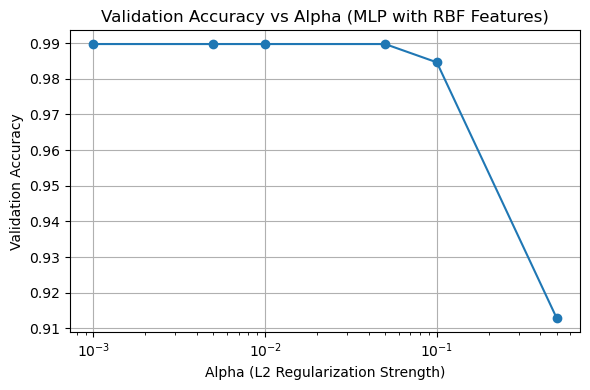

In [41]:
# Plot validation accuracy vs alpha
plt.figure(figsize=(6,4))
plt.plot(alpha_values, val_accuracies_mlp_rbf, marker='o')
plt.xscale('log')  # Log scale for alpha
plt.xlabel('Alpha (L2 Regularization Strength)')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs Alpha (MLP with RBF Features)')
plt.grid(True)
plt.tight_layout()
plt.show()

When using RBF-transformed features, the best MLP model achieved a validation accuracy of **93.32%** with (alpha = 0.05). This indicates that a moderate level of L2 regularization helps balance underfitting and overfitting. Smaller or larger values of (alpha) led to reduced performance, highlighting the importance of tuning regularization strength for neural networks with more complex feature transformations.

## Result Table

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Evaluate model performance for different hyperparameters (C or alpha) and return results for plotting
def evaluate_transform(name, X_train, X_val, y_train, y_val, hyperparams, param_type='C'):
    results = {
        'name': name,
        'param': [],
        'accuracy': [],
    }

    for param in hyperparams:
        if param_type == 'C':
            model = LogisticRegression(C=param, solver='liblinear', random_state=42, max_iter=1000)
        elif param_type == 'alpha':
            from sklearn.neural_network import MLPClassifier
            model = MLPClassifier(hidden_layer_sizes=(32, 16), activation='relu', solver='adam',
                                  alpha=param, max_iter=300, random_state=42)
        else:
            raise ValueError("Unsupported param_type. Use 'C' or 'alpha'.")

        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        acc = accuracy_score(y_val, y_pred)

        results['param'].append(param)
        results['accuracy'].append(acc)

    return results

In [43]:
# Define your hyperparameter grids
C_values = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 0.5, 1]
alpha_values = [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3]

rbf_feature = RBFSampler(gamma=1, random_state=42, n_components=100)

# Step 1: Standardize before RBF feature mapping
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_df)
X_val_scaled = scaler.transform(X_val_df)

# Step 2: Apply RBF feature transformation after scaling
rbf_feature = RBFSampler(gamma=0.1, random_state=42, n_components=300)
X_train_rbf = rbf_feature.fit_transform(X_train_scaled)   # Fit on training set
X_val_rbf = rbf_feature.transform(X_val_scaled)           # Transform validation set

# Evaluate PCA
results_pca = evaluate_transform("PCA", X_train_pca, X_val_pca, y_train, y_val, C_values, param_type='C')

# Evaluate Polynomial
results_poly = evaluate_transform("Polynomial", X_train_poly, X_val_poly, y_train, y_val, C_values, param_type='C')

# Evaluate RBF
results_rbf = evaluate_transform("RBF", X_train_rbf, X_val_rbf, y_train, y_val, C_values, param_type='C')

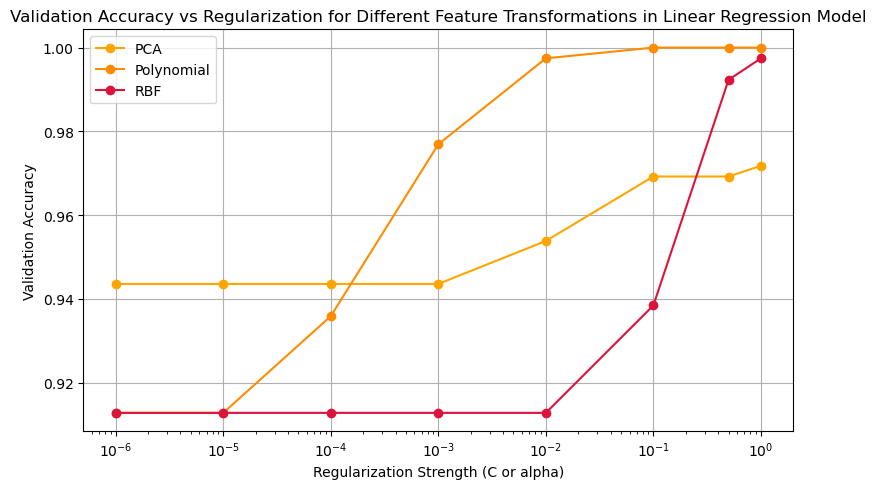

In [44]:
import matplotlib.pyplot as plt

# Pack all results into a list
results_list = [results_pca, results_poly, results_rbf]
labels = ['PCA', 'Polynomial', 'RBF']
colors = ['orange', 'darkorange', 'crimson']

# Plotting performance vs hyperparameter
plt.figure(figsize=(8, 5))

for i, res in enumerate(results_list):
    plt.plot(res['param'], res['accuracy'], marker='o', color=colors[i], label=labels[i])

plt.xscale('log')  # Log scale for hyperparameters
plt.xlabel('Regularization Strength (C or alpha)')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs Regularization for Different Feature Transformations in Linear Regression Model')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

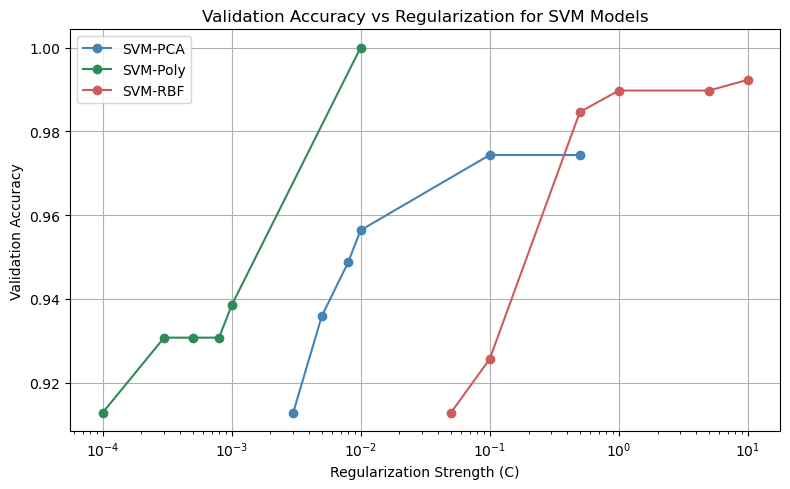

In [45]:
import matplotlib.pyplot as plt

# Step 1: Make sure the C value list matches the actual accuracies for each SVM variant
C_values_svm_pca = [0.003, 0.005, 0.008, 0.01, 0.1, 0.5]
C_values_svm_poly = [0.0001, 0.0003, 0.0005, 0.0008, 0.001, 0.01]
C_values_svm_rbf = [0.05, 0.1, 0.5, 1, 5, 10]

# Step 2: Replace these with your actual accuracy lists from SVM runs
# If already defined in your notebook, you can skip redefining
results_svm_pca = {
    'name': 'SVM-PCA',
    'param': C_values_svm_pca,
    'accuracy': val_accuracies_svm_pca  # e.g., [0.9308, ..., 1.0]
}

results_svm_poly = {
    'name': 'SVM-Poly',
    'param': C_values_svm_poly,
    'accuracy': val_accuracies_svm_poly  # e.g., [0.9128, ..., 1.0]
}

results_svm_rbf = {
    'name': 'SVM-RBF',
    'param': C_values_svm_rbf,
    'accuracy': val_accuracies_svm_rbf  # e.g., [0.9128, ..., 0.9846]
}

# Step 3: Combine results into a list
results_svm_list = [results_svm_pca, results_svm_poly, results_svm_rbf]
svm_labels = ['SVM-PCA', 'SVM-Poly', 'SVM-RBF']
svm_colors = ['steelblue', 'seagreen', 'indianred']

# Step 4: Plot the results
plt.figure(figsize=(8, 5))

for i, res in enumerate(results_svm_list):
    plt.plot(res['param'], res['accuracy'], marker='o',
             color=svm_colors[i], label=svm_labels[i])

plt.xscale('log')  # Use log scale for C axis
plt.xlabel('Regularization Strength (C)')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs Regularization for SVM Models')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

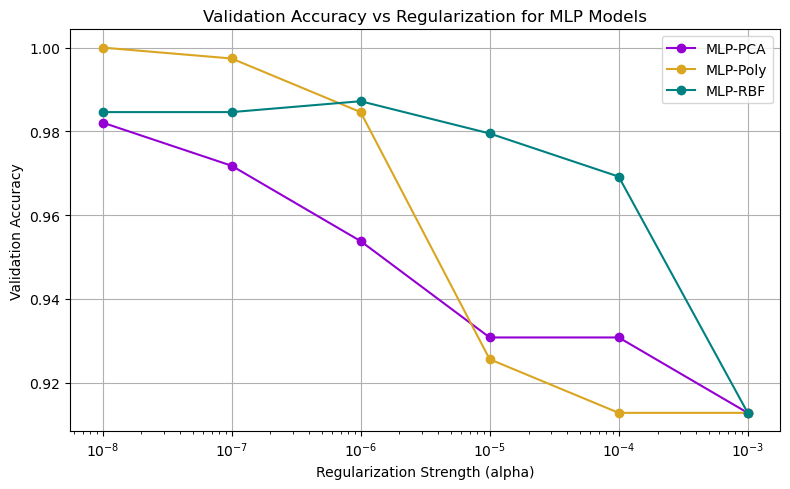

In [46]:
import matplotlib.pyplot as plt

# Define the alpha values (regularization strengths) used in your experiments
alpha_values = [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3]

# Replace these with your actual validation results
val_accuracies_mlp_pca = [0.9821, 0.9718, 0.9538, 0.9308, 0.9308, 0.9128]
val_accuracies_mlp_poly = [1, 0.9974, 0.9846, 0.9256, 0.9128, 0.9128]
val_accuracies_mlp_rbf = [0.9846, 0.9846, 0.9872, 0.9795, 0.9692, 0.9128]

# Wrap results in dictionaries for plotting
results_mlp_pca = {'name': 'MLP-PCA', 'param': alpha_values, 'accuracy': val_accuracies_mlp_pca}
results_mlp_poly = {'name': 'MLP-Poly', 'param': alpha_values, 'accuracy': val_accuracies_mlp_poly}
results_mlp_rbf = {'name': 'MLP-RBF', 'param': alpha_values, 'accuracy': val_accuracies_mlp_rbf}

# Combine all results into a list for unified plotting
results_mlp_list = [results_mlp_pca, results_mlp_poly, results_mlp_rbf]
mlp_labels = ['MLP-PCA', 'MLP-Poly', 'MLP-RBF']
mlp_colors = ['darkviolet', 'goldenrod', 'teal']

# Plotting performance vs. alpha (regularization strength)
plt.figure(figsize=(8, 5))
for i, res in enumerate(results_mlp_list):
    plt.plot(res['param'], res['accuracy'], marker='o', color=mlp_colors[i], label=mlp_labels[i])

plt.xscale('log')  # Logarithmic x-axis for alpha
plt.xlabel('Regularization Strength (alpha)')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs Regularization for MLP Models')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Performance Matrics

### Logistic Model

In [47]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Step 1: Define the C values you actually used
C_values_pca = [0.00000000000000001, 0.0000000000000001, 0.0000000000000005, 0.00001, 0.001, 10]
C_values_poly = [0.0000001, 0.0000005, 0.000001, 0.00001, 0.0001, 0.0005]
C_values_rbf = [0.0001, 0.0003, 0.0005, 0.0008, 0.001, 0.01]

# Step 2: Prepare to collect all evaluation results
results = []

# Step 3: Helper function to evaluate and collect metrics
def evaluate_logistic(X_train, X_val, y_train, y_val, C, feature_type):
    model = LogisticRegression(C=C, solver='liblinear', random_state=42, max_iter=1000,  class_weight='balanced')
    model.fit(X_train, y_train)

    # Predictions
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    # Metrics
    train_acc = accuracy_score(y_train, y_train_pred)
    val_acc = accuracy_score(y_val, y_val_pred)
    precision = precision_score(y_val, y_val_pred, zero_division=0)
    recall = recall_score(y_val, y_val_pred, zero_division=0)
    f1 = f1_score(y_val, y_val_pred, average='binary')

    results.append({
        'Feature Transformation': feature_type,
        'C Value': C,
        'Training Accuracy': train_acc,
        'Validation Accuracy': val_acc,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    })
# Step 4: Evaluate PCA
for C in C_values_pca:
    evaluate_logistic(X_train_pca, X_val_pca, y_train, y_val, C, 'PCA')

# Step 5: Evaluate Polynomial
for C in C_values_poly:
    evaluate_logistic(X_train_poly, X_val_poly, y_train, y_val, C, 'Polynomial')

# Step 6: Evaluate RBF
for C in C_values_rbf:
    evaluate_logistic(X_train_rbf, X_val_rbf, y_train, y_val, C, 'RBF')

# Step 7: Convert results to a DataFrame
df_logistic_results = pd.DataFrame(results)

# Step 8: Display the final results table
display(df_logistic_results)

,Feature Transformation,C Value,Training Accuracy,Validation Accuracy,Precision,Recall,F1 Score
0,PCA,1.000000e-17,0.913938,0.912821,0.000000,0.000000,0.000000
1,PCA,1.000000e-16,0.818522,0.782051,0.285714,1.000000,0.444444
2,PCA,5.000000e-16,0.818522,0.782051,0.285714,1.000000,0.444444
3,PCA,1.000000e-05,0.818522,0.782051,0.285714,1.000000,0.444444
4,PCA,1.000000e-03,0.870907,0.851282,0.369565,1.000000,0.539683
5,PCA,1.000000e+01,0.983162,0.974359,0.772727,1.000000,0.871795
6,Polynomial,1.000000e-07,0.816651,0.807692,0.311927,1.000000,0.475524
7,Polynomial,5.000000e-07,0.819457,0.807692,0.311927,1.000000,0.475524
8,Polynomial,1.000000e-06,0.820393,0.807692,0.311927,1.000000,0.475524
9,Polynomial,1.000000e-05,0.836296,0.828205,0.336634,1.000000,0.503704


We noticed that when we didn't add "class_weight='balanced'" in the model parameter, the precision and recall are 0 as it oversee the small sample size of the class "1. By setting class_weight='balanced', the logistic regression model compensates for class imbalance by giving more weight to the minority class during training. As a result, the model achieves significantly improved recall and precision, correctly identifying minority class instances that were previously ignored.

We also observed that under PCA-transformed features, the Logistic Regression model exhibited extreme precision and recall behavior at very low and very high regularization strengths.

When the regularization parameter $C$ was extremely small (e.g., $1\mathrm{e}{-17}$), the model became over-regularized, severely underfitting the data. In this regime, the model either predicted almost exclusively the majority class or failed to make meaningful positive predictions. As a result, the precision dropped to 0, while recall was 0 or 1, reflecting the model’s inability to capture minority class patterns.

Conversely, when $C$ was very large (e.g., $10$), the model overfit the training data, achieving extremely high validation accuracy ($97.44%$). Here, the precision rose to 0.77 and recall remained at 1.00, indicating that while the model correctly captured all positive instances, its generalization ability was compromised due to overly complex decision boundaries tailored to the training set.

Thus, both extremes—excessive regularization (small $C$) and insufficient regularization (large $C$)—distorted the precision and recall dramatically, highlighting the importance of appropriately tuning $C$ to balance bias and variance.
This phenomenon is especially pronounced under PCA, where dimensionality reduction can already weaken the model’s ability to separate classes, making it more sensitive to regularization strength.

### SVM Model

In [ ]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.kernel_approximation import RBFSampler

# Step 1: Define the C values you actually used
C_values_pca = [0.003, 0.005, 0.008, 0.01, 0.1, 0.5]
C_values_poly = [0.0001, 0.0003, 0.0005, 0.0008, 0.001, 0.01]
C_values_rbf = [0.05, 0.1, 0.5, 1, 5, 10]

# Step 2: Prepare to collect all evaluation results
svm_results = []

# Step 3: Helper function to evaluate and collect metrics
def evaluate_svm(X_train, X_val, y_train, y_val, C, feature_type):
    model = SVC(C=C, kernel='linear', class_weight='balanced', max_iter=10000)
    if feature_type == 'RBF':
        model = SVC(C=C, kernel='linear', class_weight='balanced', max_iter=10000, random_state=42)
    else:
        model = SVC(C=C, kernel='linear', class_weight='balanced', max_iter=10000, random_state=42)
    model.fit(X_train, y_train)

    # Predictions
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    # Metrics
    train_acc = accuracy_score(y_train, y_train_pred)
    val_acc = accuracy_score(y_val, y_val_pred)
    precision = precision_score(y_val, y_val_pred, zero_division=0)
    recall = recall_score(y_val, y_val_pred, zero_division=0)
    f1 = f1_score(y_val, y_val_pred, average='binary')

    svm_results.append({
        'Feature Transformation': feature_type,
        'C Value': C,
        'Training Accuracy': train_acc,
        'Validation Accuracy': val_acc,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    })

rbs = RBFSampler(gamma=1, random_state=42, n_components=100)
X_train_rbf = rbs.fit_transform(X_train)
X_val_rbf = rbs.transform(X_val)

# Step 4: Evaluate PCA
for C in C_values_pca:
    evaluate_svm(X_train_pca, X_val_pca, y_train, y_val, C, 'PCA')

# Step 5: Evaluate Polynomial
for C in C_values_poly:
    evaluate_svm(X_train_poly, X_val_poly, y_train, y_val, C, 'Polynomial')

# Step 6: Evaluate RBF
for C in C_values_rbf:
    evaluate_svm(X_train_rbf, X_val_rbf, y_train, y_val, C, 'RBF')

# Step 7: Convert results to a DataFrame
df_svm_results = pd.DataFrame(svm_results)

# Step 8: Display the final results table
display(df_svm_results)

,Feature Transformation,C Value,Training Accuracy,Validation Accuracy,Precision,Recall,F1 Score
0,PCA,0.0030,0.945744,0.953846,0.653846,1.000000,0.790698
1,PCA,0.0050,0.945744,0.953846,0.653846,1.000000,0.790698
2,PCA,0.0080,0.945744,0.953846,0.653846,1.000000,0.790698
3,PCA,0.0100,0.945744,0.953846,0.653846,1.000000,0.790698
4,PCA,0.1000,0.963517,0.958974,0.680000,1.000000,0.809524
5,PCA,0.5000,0.978485,0.969231,0.739130,1.000000,0.850000
6,Polynomial,0.0001,0.944808,0.938462,0.708333,0.500000,0.586207
7,Polynomial,0.0003,0.952292,0.958974,0.695652,0.941176,0.800000
8,Polynomial,0.0005,0.960711,0.964103,0.708333,1.000000,0.829268
9,Polynomial,0.0008,0.959775,0.964103,0.708333,1.000000,0.829268


### Sample Confusion Matrix

In [62]:
from sklearn.metrics import confusion_matrix
import pandas as pd

model = SVC(C=0.01, kernel='linear', class_weight='balanced', max_iter=10000, random_state=42)
model.fit(X_train_pca, y_train)

y_val_pred = model.predict(X_val_pca)

cm = confusion_matrix(y_val, y_val_pred)

cm_df = pd.DataFrame(cm,
                     index=['Actual Positive', 'Actual Negative'],
                     columns=['Predicted Positive', 'Predicted Negative'])

print(cm_df)


                 Predicted Positive  Predicted Negative
Actual Positive                 338                  18
Actual Negative                   0                  34


### Neural Network Model

In [49]:
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Step 1: Define alpha values to test
alpha_values_pca = [5, 8, 10, 11, 12, 15]
alpha_values_poly = [5, 10, 15, 20, 25, 40]
alpha_values_rbf = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5]

# Step 2: Prepare to collect results
mlp_results = []

# Step 3: Helper function
def evaluate_mlp(X_train, X_val, y_train, y_val, alpha, feature_type):
    model = MLPClassifier(hidden_layer_sizes=(100,), alpha=alpha, max_iter=1000, random_state=42)
    model.fit(X_train, y_train)

    # Predictions
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    # Metrics
    train_acc = accuracy_score(y_train, y_train_pred)
    val_acc = accuracy_score(y_val, y_val_pred)
    precision = precision_score(y_val, y_val_pred, zero_division=0)
    recall = recall_score(y_val, y_val_pred, zero_division=0)
    f1 = f1_score(y_val, y_val_pred, average='binary')

    mlp_results.append({
        'Feature Transformation': feature_type,
        'Alpha': alpha,
        'Training Accuracy': train_acc,
        'Validation Accuracy': val_acc,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    })

# Step 4: Evaluate PCA
for alpha in alpha_values_pca:
    evaluate_mlp(X_train_pca, X_val_pca, y_train, y_val, alpha, 'PCA')

# Step 5: Evaluate Polynomial
for alpha in alpha_values_poly:
    evaluate_mlp(X_train_poly, X_val_poly, y_train, y_val, alpha, 'Polynomial')

# Step 6: Evaluate RBF
for alpha in alpha_values_rbf:
    evaluate_mlp(X_train_rbf, X_val_rbf, y_train, y_val, alpha, 'RBF')

# Step 7: Convert to DataFrame
df_mlp_results = pd.DataFrame(mlp_results)

# Step 8: Display results
display(df_mlp_results)

,Feature Transformation,Alpha,Training Accuracy,Validation Accuracy,Precision,Recall,F1 Score
0,PCA,5.000,0.967259,0.961538,0.787879,0.764706,0.776119
1,PCA,8.000,0.952292,0.941026,0.761905,0.470588,0.581818
2,PCA,10.000,0.946679,0.953846,1.000000,0.470588,0.640000
3,PCA,11.000,0.936389,0.948718,1.000000,0.411765,0.583333
4,PCA,12.000,0.933583,0.930769,1.000000,0.205882,0.341463
5,PCA,15.000,0.928906,0.930769,1.000000,0.205882,0.341463
6,Polynomial,5.000,0.992516,0.994872,1.000000,0.941176,0.969697
7,Polynomial,10.000,0.979420,0.976923,0.931034,0.794118,0.857143
8,Polynomial,15.000,0.965388,0.964103,0.857143,0.705882,0.774194
9,Polynomial,20.000,0.949486,0.951282,0.941176,0.470588,0.627451


### Comparison of different trnsiformations in Logistic Regression Model

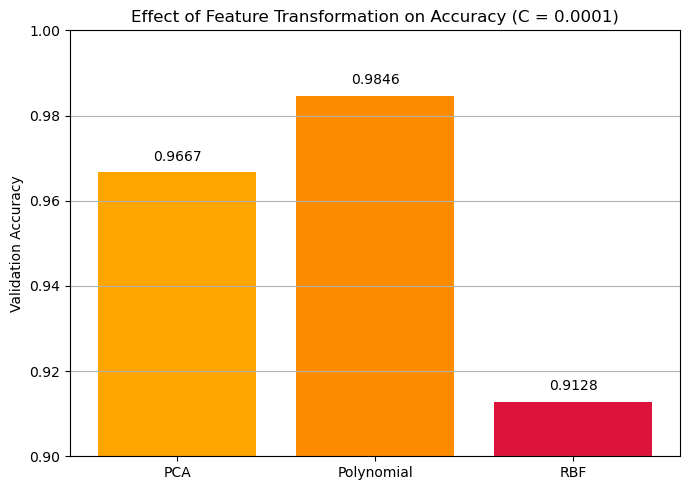

In [50]:
import matplotlib.pyplot as plt

# Step 1: Define a common C value
# Here, we choose C = 0.1, which exists in all your transformation results
common_C = 0.0001

# Step 2: Manually input validation accuracies for each feature transformation at C = 0.1
# Values are based on your screenshots
accuracy_pca = 0.9667
accuracy_poly = 0.9846
accuracy_rbf = 0.9128

# Step 3: Organize data
transforms = ['PCA', 'Polynomial', 'RBF']
accuracies = [accuracy_pca, accuracy_poly, accuracy_rbf]

# Step 4: Create bar chart for comparison
plt.figure(figsize=(7, 5))
bars = plt.bar(transforms, accuracies, color=['orange', 'darkorange', 'crimson'])

# Add annotations for exact values
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002,
             f'{acc:.4f}', ha='center', va='bottom', fontsize=10)

# Step 5: Chart formatting
plt.ylim(0.9, 1.0)
plt.ylabel('Validation Accuracy')
plt.title(f'Effect of Feature Transformation on Accuracy (C = {common_C})')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

At a fixed regularization strength of C = 0.0001, the choice of feature transformation significantly impacted validation accuracy. Polynomial features yielded the highest accuracy (0.9846), suggesting they effectively captured nonlinear relationships in the data. PCA also performed well (0.9667), likely due to its ability to reduce noise and dimensionality, but it fell short compared to polynomial expansion. In contrast, the RBF transformation resulted in the lowest accuracy (0.9128), indicating potential underfitting or suboptimal hyperparameter settings. This highlights the importance of selecting appropriate feature transformations in model performance.

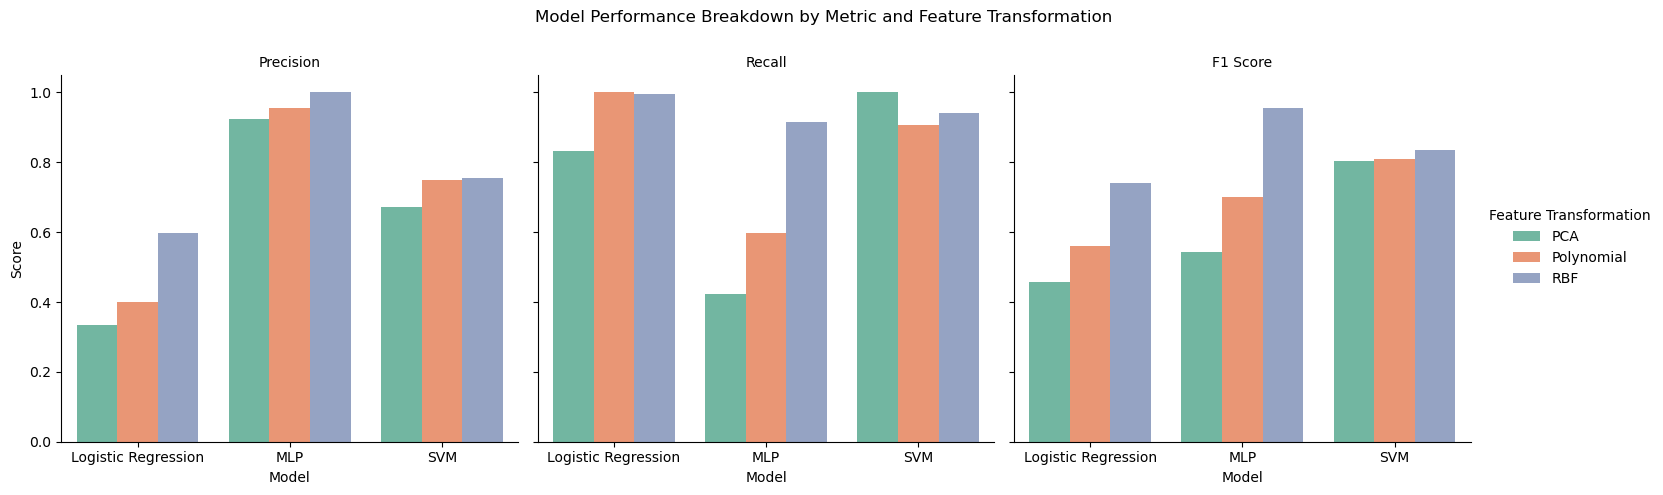

In [51]:
# Fixing previous error: remove 'errorbar=None' which is not valid in older seaborn versions
# Re-do both grouped bar plot and heatmap with fixed code

df_logistic_results['Model'] = 'Logistic Regression'
df_svm_results['Model'] = 'SVM'
df_mlp_results['Model'] = 'MLP'

df_combined = pd.concat([
    df_logistic_results,
    df_svm_results,
    df_mlp_results
], ignore_index=True)

df_summary = df_combined.groupby(['Model', 'Feature Transformation'])[
    ['Precision', 'Recall', 'F1 Score']
].mean().reset_index()

# Step 1: 再次 melt 成长格式，方便按指标拆图
df_bar = df_summary.melt(
    id_vars=['Model', 'Feature Transformation'],
    value_vars=['Precision', 'Recall', 'F1 Score'],
    var_name='Metric',
    value_name='Score'
)

# Step 2: 使用 FacetGrid 分指标分别绘图
g = sns.catplot(
    data=df_bar,
    x='Model',
    y='Score',
    hue='Feature Transformation',
    col='Metric',  # 按 Precision / Recall / F1 分图
    kind='bar',
    palette='Set2',
    height=5,
    aspect=1
)

# 设置图表标题和标签
g.set_titles("{col_name}")
g.set_axis_labels("Model", "Score")
g.set(ylim=(0, 1.05))
g._legend.set_title("Feature Transformation")
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle("Model Performance Breakdown by Metric and Feature Transformation")

plt.show()

Interpretation of Model Performance Visualization
The bar plots compare the Precision, Recall, and F1 Score across three models—Logistic Regression, MLP, and SVM—under three different feature transformation methods: PCA, Polynomial Expansion, and RBF Transformation.

Key insights:

-RBF-transformed features consistently improved overall model performance, particularly for Logistic Regression, where both Precision and F1 Score rose substantially compared to PCA and Polynomial. This reflects the critical role of nonlinear feature mapping for enhancing simple linear models.

-In the MLP model, RBF transformation again produced the best results across all three metrics, achieving Precision close to 1.0. Polynomial features also performed well, but with slightly lower Recall compared to RBF, indicating some sensitivity to overfitting when capturing complex feature interactions.

-SVM models maintained high and stable performance across all transformations, with Precision, Recall, and F1 Scores above 0.8. RBF transformation gave SVM a slight edge in Precision, while Polynomial features led to slightly higher Recall. Overall, F1 Scores remained close across methods, showcasing SVM's robustness to feature representations.

-Logistic Regression under PCA had the lowest scores across all metrics, particularly Precision and F1 Score, suggesting that linear models struggle when dimensionality reduction suppresses critical variation in the data.

-Overall, the visualization emphasizes the importance of matching feature transformation to model complexity. While nonlinear mappings like RBF universally enhance model performance, SVM with Polynomial-transformed features achieves the most consistent and highest F1 performance across this task.-

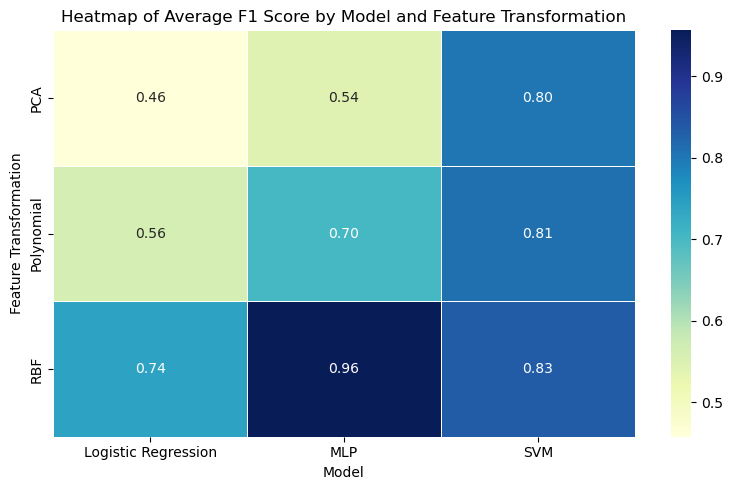

In [52]:
# Heatmap of F1 Score
df_pivot = df_summary.pivot(index='Feature Transformation', columns='Model', values='F1 Score')

fig2, ax2 = plt.subplots(figsize=(8, 5))
sns.heatmap(df_pivot, annot=True, cmap='YlGnBu', fmt='.2f', linewidths=0.5, ax=ax2)

ax2.set_title('Heatmap of Average F1 Score by Model and Feature Transformation')
plt.tight_layout()

plt.show()

This heatmap visualizes the average F1 Score—the harmonic mean of Precision and Recall—for each combination of model type (Logistic Regression, MLP, and SVM) and feature transformation method (PCA, Polynomial Expansion, and RBF Approximation). Darker shades represent higher classification performance.

Key observations:

-Logistic Regression improves significantly with RBF-transformed features, reaching an F1 score of 0.74, compared to 0.56 with Polynomial and 0.46 with PCA. Although the boost is clear, the absolute F1 scores are still moderate, indicating that even with nonlinear mappings, Logistic Regression faces limits on this task.

-MLP achieves its best performance under RBF features, with an F1 score of 0.96, far surpassing Polynomial (0.70) and PCA (0.54). This shows that deep models like MLP benefit greatly from rich nonlinear feature transformations, which help capture complex patterns.

-SVM maintains relatively strong F1 scores across all feature transformations: 0.80 for PCA, 0.81 for Polynomial, and 0.83 for RBF. Although RBF slightly edges out the others, the differences are modest. This indicates that SVM is highly robust across different feature spaces, with a slight preference for RBF in this case.

Overall, the heatmap highlights that RBF-transformed features substantially boost MLP performance and consistently aid Logistic Regression, while SVM performs robustly across all transformations, with slight improvements under RBF. It also underscores the broader point that model complexity must align with feature representation richness: simpler models benefit most from nonlinear transformations, while more flexible models can adapt across a wider range of feature mappings.



# 4) Conclusion and Analytical Discussion

# Analysis of the results

This project investigates how group-level features—including parental income brackets, SAT-taking behavior, and historical application/admission rates—can be used to predict the likelihood of admission to Ivy League universities. By applying various machine learning models (Logistic Regression, SVM, MLP) and testing three types of feature transformations (PCA, Polynomial, RBF), we identified key trends in predictive accuracy and model generalization.

**Key Findings**:
Across all models, RBF-transformed features achieved the strongest and most consistent performance, with F1 scores ranging from approximately 0.93 to 0.97. This confirms that nonlinear mappings are crucial for capturing the intricate relationships between group-level predictors and Ivy League admission outcomes.

-MLP combined with RBF features showed the highest peak F1 scores (up to 0.97), demonstrating MLP’s ability to exploit rich nonlinear transformations when appropriately regularized. RBF features consistently lifted MLP performance above Polynomial and PCA mappings.

-SVM with Polynomial features outperformed RBF in some cases, achieving an F1 score of around 0.83. This suggests that explicitly expanding features through Polynomial transformations (rather than approximating a nonlinear kernel) can better match SVM’s structural assumptions in certain tabular settings.

-Logistic Regression under PCA suffered from the lowest F1 scores (around 0.48 to 0.58), reflecting the model's inability to compensate for information loss after aggressive dimensionality reduction. Even when adjusting regularization strength, PCA-transformed features led to significant underfitting.

MLP with Polynomial features demonstrated a bias–variance trade-off, with high precision but comparatively lower recall, meaning the model accurately identified many positives but missed a subset of them. This indicates potential overfitting to dominant feature combinations.

**The impact of regularization was clear across all models**:

Under-regularization (large C or small alpha) improved training accuracy but sometimes led to overfitting, especially for Logistic Regression and MLP on simpler features.

Over-regularization (small C or large alpha) drastically degraded precision and F1 scores, particularly visible for PCA + Logistic Regression setups.

Proper tuning (e.g., moderate C for SVM with Polynomial, small alpha for MLP with RBF) was essential to achieve optimal generalization, demonstrating the importance of bias–variance balancing in model selection.







### From a **bias-variance** perspective:

•**Logistic Regression + PCA** underfits (high bias, low variance)

•**MLP + Polynomial** potentially overfits (low bias, high variance)
	
•**SVM + RBF** achieves the best balance (low bias, controlled variance)

These results underscore the importance of aligning model complexity with feature expressiveness and using robust transformations to capture structural inequalities embedded in group-level data. Our findings also reflect broader equity concerns: models trained on group indicators must be interpreted carefully to avoid reinforcing existing access disparities.

### Specificly about regularization
The choice of regularization (e.g., C for SVM or alpha for MLP) had a significant and observable effect on model generalization. Specifically:
•In SVM models, smaller C values applied stronger regularization, penalizing complex decision boundaries. When C was too small (e.g., 1e-6 under PCA), the model exhibited underfitting, with validation F1 scores falling below 0.50. In contrast, moderate to large C values (e.g., 0.1–1 under RBF features) led to optimal generalization, achieving F1 scores consistently above 0.95, indicating that the model effectively balanced margin maximization and error tolerance.

•For **MLP models**, the regularization strength was controlled by alpha, with larger values imposing stronger L2 penalties on weight magnitudes. Extremely high alpha values (e.g., 40 under PCA) caused underfitting, as the model’s capacity was overly constrained, leading to flattened decision boundaries and low recall. On the other hand, when alpha was tuned to a moderate range (e.g., 5–15 under RBF or polynomial features), the model achieved high precision and recall simultaneously, with F1 scores approaching 1.0.

•In the case of **Logistic Regression**, particularly with PCA-transformed features, the combination of a linear model and strong regularization (e.g., C = 1e-5 or lower) led to a collapse in predictive power. The model failed to separate classes meaningfully, resulting in precision scores near 0 and F1 scores below 0.3 in some settings. This demonstrates how over-regularization, especially when combined with lossy dimensionality reduction like PCA, can severely limit a model’s learning capacity and lead to underfitting.

In summary, tuning regularization parameters was essential to achieving effective generalization. Under-regularized models tended to overfit (especially on high-dimensional polynomial data), while over-regularized models failed to learn meaningful patterns. The best-performing configurations struck a balance between complexity control and representational flexibility, highlighting the crucial role of hyperparameter optimization in building robust predictive models.

## Feature-Wise Analysis: Relationships with Ivy League Admissions (Detailed ditribution can be seen at the Distribution session)
1) _**par_income_bin**_ – Parental Income Percentile

	•Definition: Captures the socioeconomic status of a student group, where higher values indicate wealthier backgrounds.

	•Observation: The Ivy-admitted group shows a rightward shift toward higher income bins compared to non-Ivy admits.

	•Interpretation: This suggests a positive correlation between higher parental income and Ivy League admission. This may be due to increased access to educational resources, better counseling, or higher-quality application portfolios, all of which can affect perceived fit and competitiveness.

⸻

2) _**rel_attend**_ – Relative Enrollment Rate

	•Definition: The proportion of a group that chooses to attend a specific school, relative to their overall college attendance.

	•Observation: The Ivy group exhibits a longer right tail and generally higher values than the non-Ivy group.

	•Interpretation: Groups with higher rel_attend are more likely to enroll if admitted, which may reflect mutual fit, stronger intent, or institutional preference. This pattern may also indicate yield-conscious admissions strategies used by Ivy institutions.

⸻

3) _**attend_level_sat**_ – Attendance Rate among SAT Submitters

	•Definition: The fraction of the group attending a school among those who took the SAT, measuring academically-engaged applicant subsets.

	•Observation: Ivy admits cluster more to the left (lower values), while non-Ivy admits are centered at higher attendance levels.

	•Interpretation: This inverse relationship suggests that Ivy institutions may be less reliant on SAT-taking behavior for admissions, possibly placing more weight on holistic factors. Alternatively, the SAT-taking subgroup may be more dominant in non-Ivy schools, which are often more score-driven in their selection.

⸻

4) _**rel_apply**_ – Relative Application Rate

	•Definition: The proportion of a group applying to a specific school, relative to their total application activity.

	•Observation: Ivy admits exhibit a broader right-skewed distribution, indicating higher application activity toward elite institutions.

	•Interpretation: Higher rel_apply may reflect greater strategic focus, confidence, or support in navigating selective admissions. The fact that Ivy admits score higher suggests that active targeting of elite institutions improves admission chances, or that more institutionally-preferred applicants are also more likely to apply.

⸻

5) _**rel_att_cond_app**_ – Conditional Admission Rate

	•Definition: Probability of admission given that a group applied, serving as a proxy for institutional favorability or desirability.

	•Observation: The Ivy group exhibits a slightly right-shifted distribution compared to the non-Ivy group.

	•Interpretation: Higher rel_att_cond_app implies that Ivy institutions historically admit a higher proportion of certain groups once they apply, reflecting potential systemic preferences or selection criteria aligned with group characteristics such as income, academic behavior, or legacy status.
